In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    #'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
def read_logfile(logfile_name):
    all_values = []
    value_labels = ['num_attention_heads', 'hidden_size', 'train_micro_batch_size_per_gpu',
                    'tensor_mp_size', 'pipeline_mp_size', 'dp_size',]
    with open(logfile_name, 'r') as f:
        reading_estimate = False
        for line in f:
            line = line.strip()
            if line == "Estimate":
                reading_estimate = True
            elif line == "Actual":
                reading_estimate = False
            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'train_micro_batch_size_per_gpu: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))
                all_values.append(values)

            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'microbatch_size: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
                             
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))
                all_values.append(values)

            match = re.match(r'Throughput \(in TFLOP/s\) for attention_key_value_query_transform \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_key_value_query_transform"] = throughput
            
            match = re.match(r'Throughput \(in TFLOP/s\) for attention_key_query_prob \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_key_query_prob"] = throughput

            match = re.match(r'Throughput \(in TFLOP/s\) for attention_prob_times_values \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_prob_times_values"] = throughput
            
            match = re.match(r'Throughput \(in TFLOP/s\) for attention_linear_projection \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["attention_linear_projection"] = throughput 

            match = re.match(r'Throughput \(in TFLOP/s\) for mlp_h_to_4h \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["mlp_h_to_4h"] = throughput  

            match = re.match(r'Throughput \(in TFLOP/s\) for mlp_4h_to_h \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    all_values[-1]["mlp_4h_to_h"] = throughput 
                
            match = re.match(r'Attention throughput \(in TFLOP/s\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_attention_throughput"] = throughput
                else:
                   all_values[-1]["actual_attention_throughput"] = throughput 

            match = re.match(r'Transformer duration \(in seconds\): (\d+\.\d+)', line)
            if match is not None:
                duration = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_duration"] = duration
                else:
                    all_values[-1]["actual_duration"] = duration
            match = re.match(r'Transformer throughput \(in TFLOP/s\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_throughput"] = throughput
                else:
                    all_values[-1]["actual_throughput"] = throughput
    return all_values

def read_logfile_base(logfile_name):
    all_values = []
    value_labels = ['num_attention_heads', 'hidden_size', 'microbatch_size',
                    'tensor_mp_size', 'pipeline_mp_size', 'dp_size']
    with open(logfile_name, 'r') as f:
        reading_estimate = False
        for line in f:
            line = line.strip()
            if line == "Estimate":
                reading_estimate = True
            elif line == "Actual":
                reading_estimate = False
            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'microbatch_size: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))
                all_values.append(values)
            match = re.match(r'Transformer duration \(in seconds\): (\d+\.\d+)', line)
            if match is not None:
                duration = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_duration"] = duration
                else:
                    all_values[-1]["actual_duration"] = duration
            match = re.match(r'Transformer throughput \(in TFLOP/s\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(1))
                if reading_estimate:
                    all_values[-1]["estimated_throughput"] = throughput
                else:
                    all_values[-1]["actual_throughput"] = throughput
    return all_values

In [3]:
def read_repeats(logfile_name):
    throughputs = []
    value_labels = ['num_attention_heads', 'hidden_size', 'train_micro_batch_size_per_gpu',
                    'tensor_mp_size', 'pipeline_mp_size', 'dp_size',]
    with open(logfile_name, 'r') as f:
        reading_estimate = False
        for line in f:
            line = line.strip()
            if line == "Estimate":
                reading_estimate = True
            elif line == "Actual":
                reading_estimate = False
            match = re.match(r'num_attention_heads: (\d+), hidden_size: (\d+), '
                             r'train_micro_batch_size_per_gpu: (\d+), tensor_mp_size: (\d+), '
                             r'pipeline_mp_size: (\d+), dp_size: (\d+)', line)
            if match is not None:
                values = {}
                for i in range(1, 7):
                    values[value_labels[i-1]] = int(match.group(i))

            
            match = re.match(r'Throughput \(in TFLOP/s\) for attention_linear_projection \((.*)\): (\d+\.\d+)', line)
            if match is not None:
                throughput = float(match.group(2))
                if reading_estimate:
                    throughputs.append(throughput)

            
    return throughputs

In [4]:
label_mapping = {'tensor_mp_size': 'TMP'}

def is_in_group(durations, group):
    match = True
    for group_key in group:
        if durations[group_key] != group[group_key]:
            match = False
    return match

def get_label(group):
    return ", ".join([f"{label_mapping[k]}={v}" for (k, v) in group.items()])

def plot_estimate_vs_actual(all_values,
                            value_type_to_plot,
                            groups,
                            xlabel, ylabel,
                            min_x_and_y_value, max_x_and_y_value,
                            output_filename=None):
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    (max_x, max_y) = (None, None)
    (min_x, min_y) = (None, None)
    for group in groups:
        x_and_y_values = [(values['estimated_%s' % value_type_to_plot],
                           values['actual_%s' % value_type_to_plot])
                          for values in all_values if is_in_group(values, group)]
        ax.scatter([x for (x, _) in x_and_y_values],
                   [y for (_, y) in x_and_y_values],
                   marker='o', label=get_label(group))
    ax.plot([x for x in arange(min_x_and_y_value, max_x_and_y_value, 0.001)],
            [y for y in arange(min_x_and_y_value, max_x_and_y_value, 0.001)],
            color='k', linestyle=':')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_xscale('log', base=10)
    # ax.set_yscale('log', base=10)
    sns.despine()
    plt.legend(frameon=False, ncol=2)    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

In [5]:

def plot_hidden_sweep(all_values,plot_value, title, point_plot=None, output_filename=None):
    ylabel="Throughput \n (TFLOP/s)"
    num_heads = [{'num_attention_heads': 64}]
    min_size = 9472-128 #10240-128
    max_size = 12032 #32768+128
    plt.figure(figsize=(12,5),dpi=500)
    ax=plt.subplot2grid((1,1),(0,0),colspan=1)
    colors = ['r','b']
    alphas = [1,0.4]
    for i in range(len(num_heads)):
        x_and_y_values = [(values['hidden_size'],
                           values[plot_value])
                          for values in all_values 
                          if is_in_group(values, num_heads[i]) 
                          #and values['hidden_size'] <= max_size 
                          #and values['hidden_size'] >= min_size 
                          #and values['hidden_size'] %64==0
        ]
        ax.plot([x for (x, _) in x_and_y_values],
                [y for (_, y) in x_and_y_values],
                marker='o',
                color = colors[i],
                alpha = alphas[i],
                label=f"n: {num_heads[i].get('num_attention_heads')}")
        if point_plot:
            ax.plot(point_plot,[values[plot_value] 
                       for values in all_values 
                       if is_in_group(values, num_heads[i]) 
                       and values['hidden_size'] in point_plot], 
                       color='black',marker='o')
    plt.legend(frameon=False, ncol=2, loc="upper left")
    ax.set_xlabel("Hidden Size")
    ax.set_ylabel(ylabel)
    #ax.set_title(title)
    sns.despine()
    #ax.xaxis.set_ticks(np.linspace(min_size,max_size,5))
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    

In [6]:

def plot_cutlass_v_pytorch(cutlass_values, pytorch_values, plot_value, output_filename=None):
    ylabel="Throughput \n (TFLOP/s)"
    num_heads = [{'num_attention_heads': 64}]
    min_size = 9472-128 #10240-128
    max_size = 12032 #32768+128
    plt.figure(figsize=(12,5),dpi=500)
    ax=plt.subplot2grid((1,1),(0,0),colspan=1)
    colors = ['r','b']
    alphas = [1,0.4]
    for i in range(len(num_heads)):
        x_and_y_values = [(values['hidden_size'],
                           values[plot_value])
                          for values in cutlass_values 
                          if is_in_group(values, num_heads[i]) 

        ]
        ax.plot([x for (x, _) in x_and_y_values],
                [y for (_, y) in x_and_y_values],
                marker='o',
                alpha = alphas[i],
                label=f"cutlass")


        x_and_y_values = [(values['hidden_size'],
                           values[plot_value])
                          for values in pytorch_values 
                          if is_in_group(values, num_heads[i]) 

        ]
        ax.plot([x for (x, _) in x_and_y_values],
                [y for (_, y) in x_and_y_values],
                marker='o',
                alpha = alphas[i],
                label=f"pytorch")
       
    plt.legend(frameon=False, ncol=2, loc="upper left")
    ax.set_xlabel("Hidden Size")
    ax.set_ylabel(ylabel)
    ax.set_title(plot_value)
    sns.despine()
    #ax.xaxis.set_ticks(np.linspace(min_size,max_size,5))
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')

In [7]:

def plot_throughputs(a100_throughputs, v100_throughputs, xaxis_variable,
                     xlabel, plot_value, ylabel, output_filename=None, markevery=1):
    plt.figure(figsize=(12, 5),dpi=500)
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    for throughputs, label in zip([a100_throughputs, v100_throughputs],
                                  ["A100", "V100"]):
        x_and_y_values = [(x[xaxis_variable], x[plot_value])
                          for x in throughputs]
        ax.plot([value[0] for value in x_and_y_values],
                [value[1] for value in x_and_y_values],
                label=label, marker='o', markevery=markevery)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(frameon=False)    
    sns.despine()
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

In [8]:
def plot_throughputs_hsweep(a100_throughputs, v100_throughputs, xaxis_variable,
                     xlabel, plot_value, ylabel, output_filename=None, markevery=1):
    plt.figure(figsize=(12, 5),dpi=500)
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    num_heads = [{'num_attention_heads': 128},{'num_attention_heads': 64}]
    for throughputs, label in zip([a100_throughputs, v100_throughputs],
                                  ["A100", "V100"]):
        x_and_y_values = [(x[xaxis_variable], x[plot_value])
                          for x in throughputs if x['num_attention_heads']==128]
        ax.plot([value[0] for value in x_and_y_values],
                [value[1] for value in x_and_y_values],
                label=label, marker='o', markevery=markevery, alpha=0.7)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend(frameon=False)    
    sns.despine()
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

In [9]:
plot_throughputs(read_logfile("scripts/A100_n_sweep.out"),read_logfile("scripts/V100_n_sweep.out"),
                 "num_attention_heads","Number of Attention Heads", "attention_key_query_prob","Throughput \n (TFLOP/s)")

FileNotFoundError: [Errno 2] No such file or directory: 'scripts/A100_n_sweep.out'

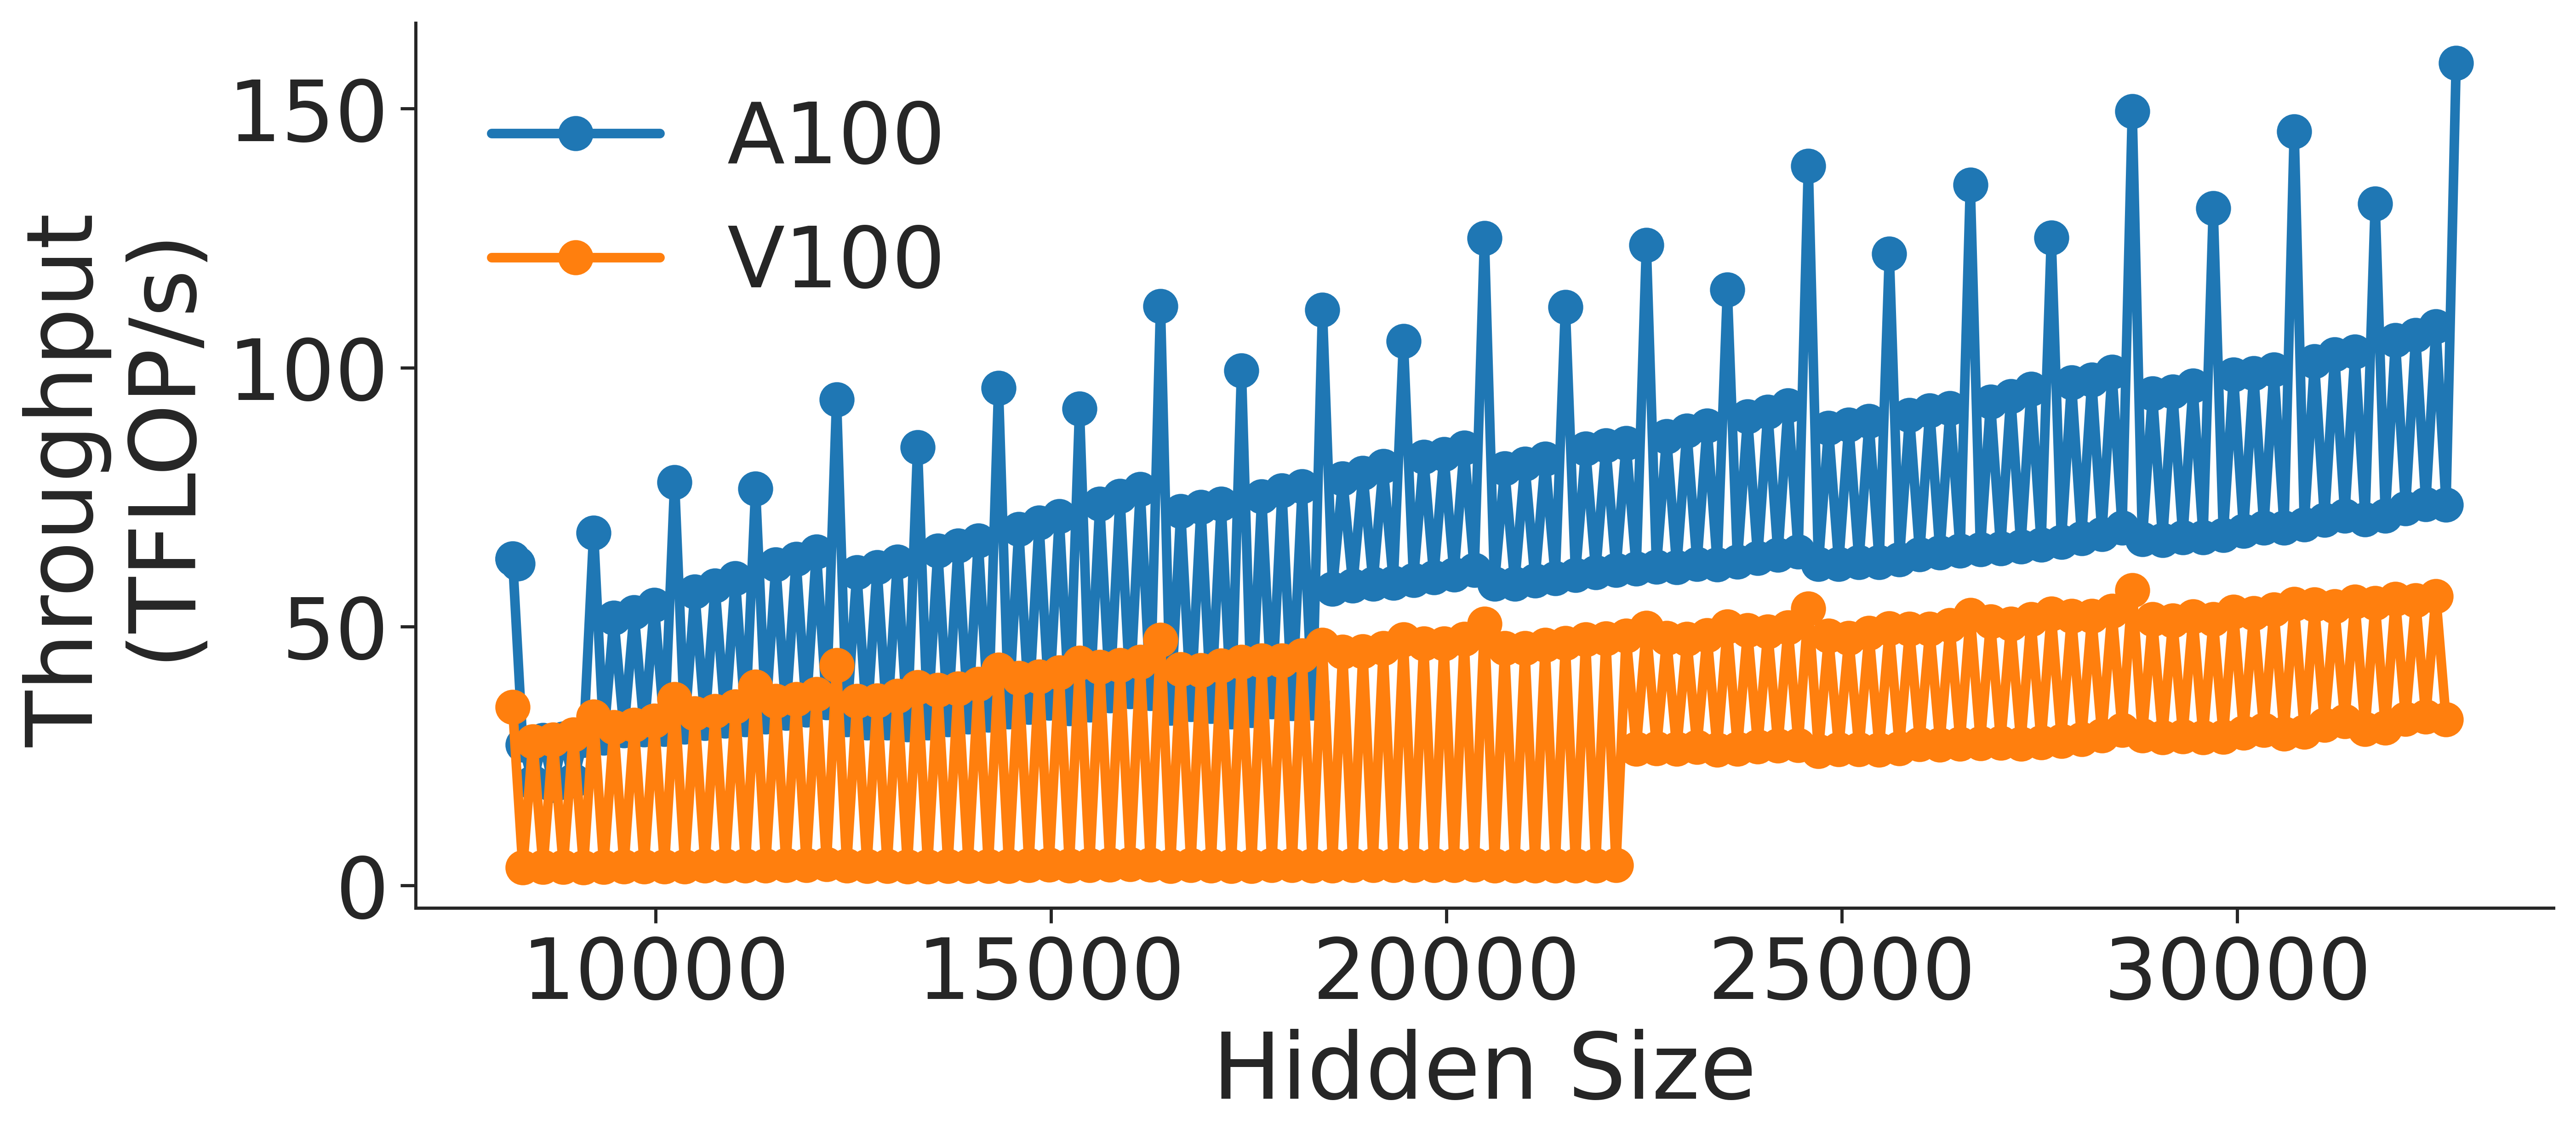

In [ ]:
plot_throughputs_hsweep(read_logfile("scripts/median_h_sweep.txt"),read_logfile("scripts/V100_h_sweep.out"),
                 "hidden_size","Hidden Size", "attention_key_query_prob","Throughput \n (TFLOP/s)")

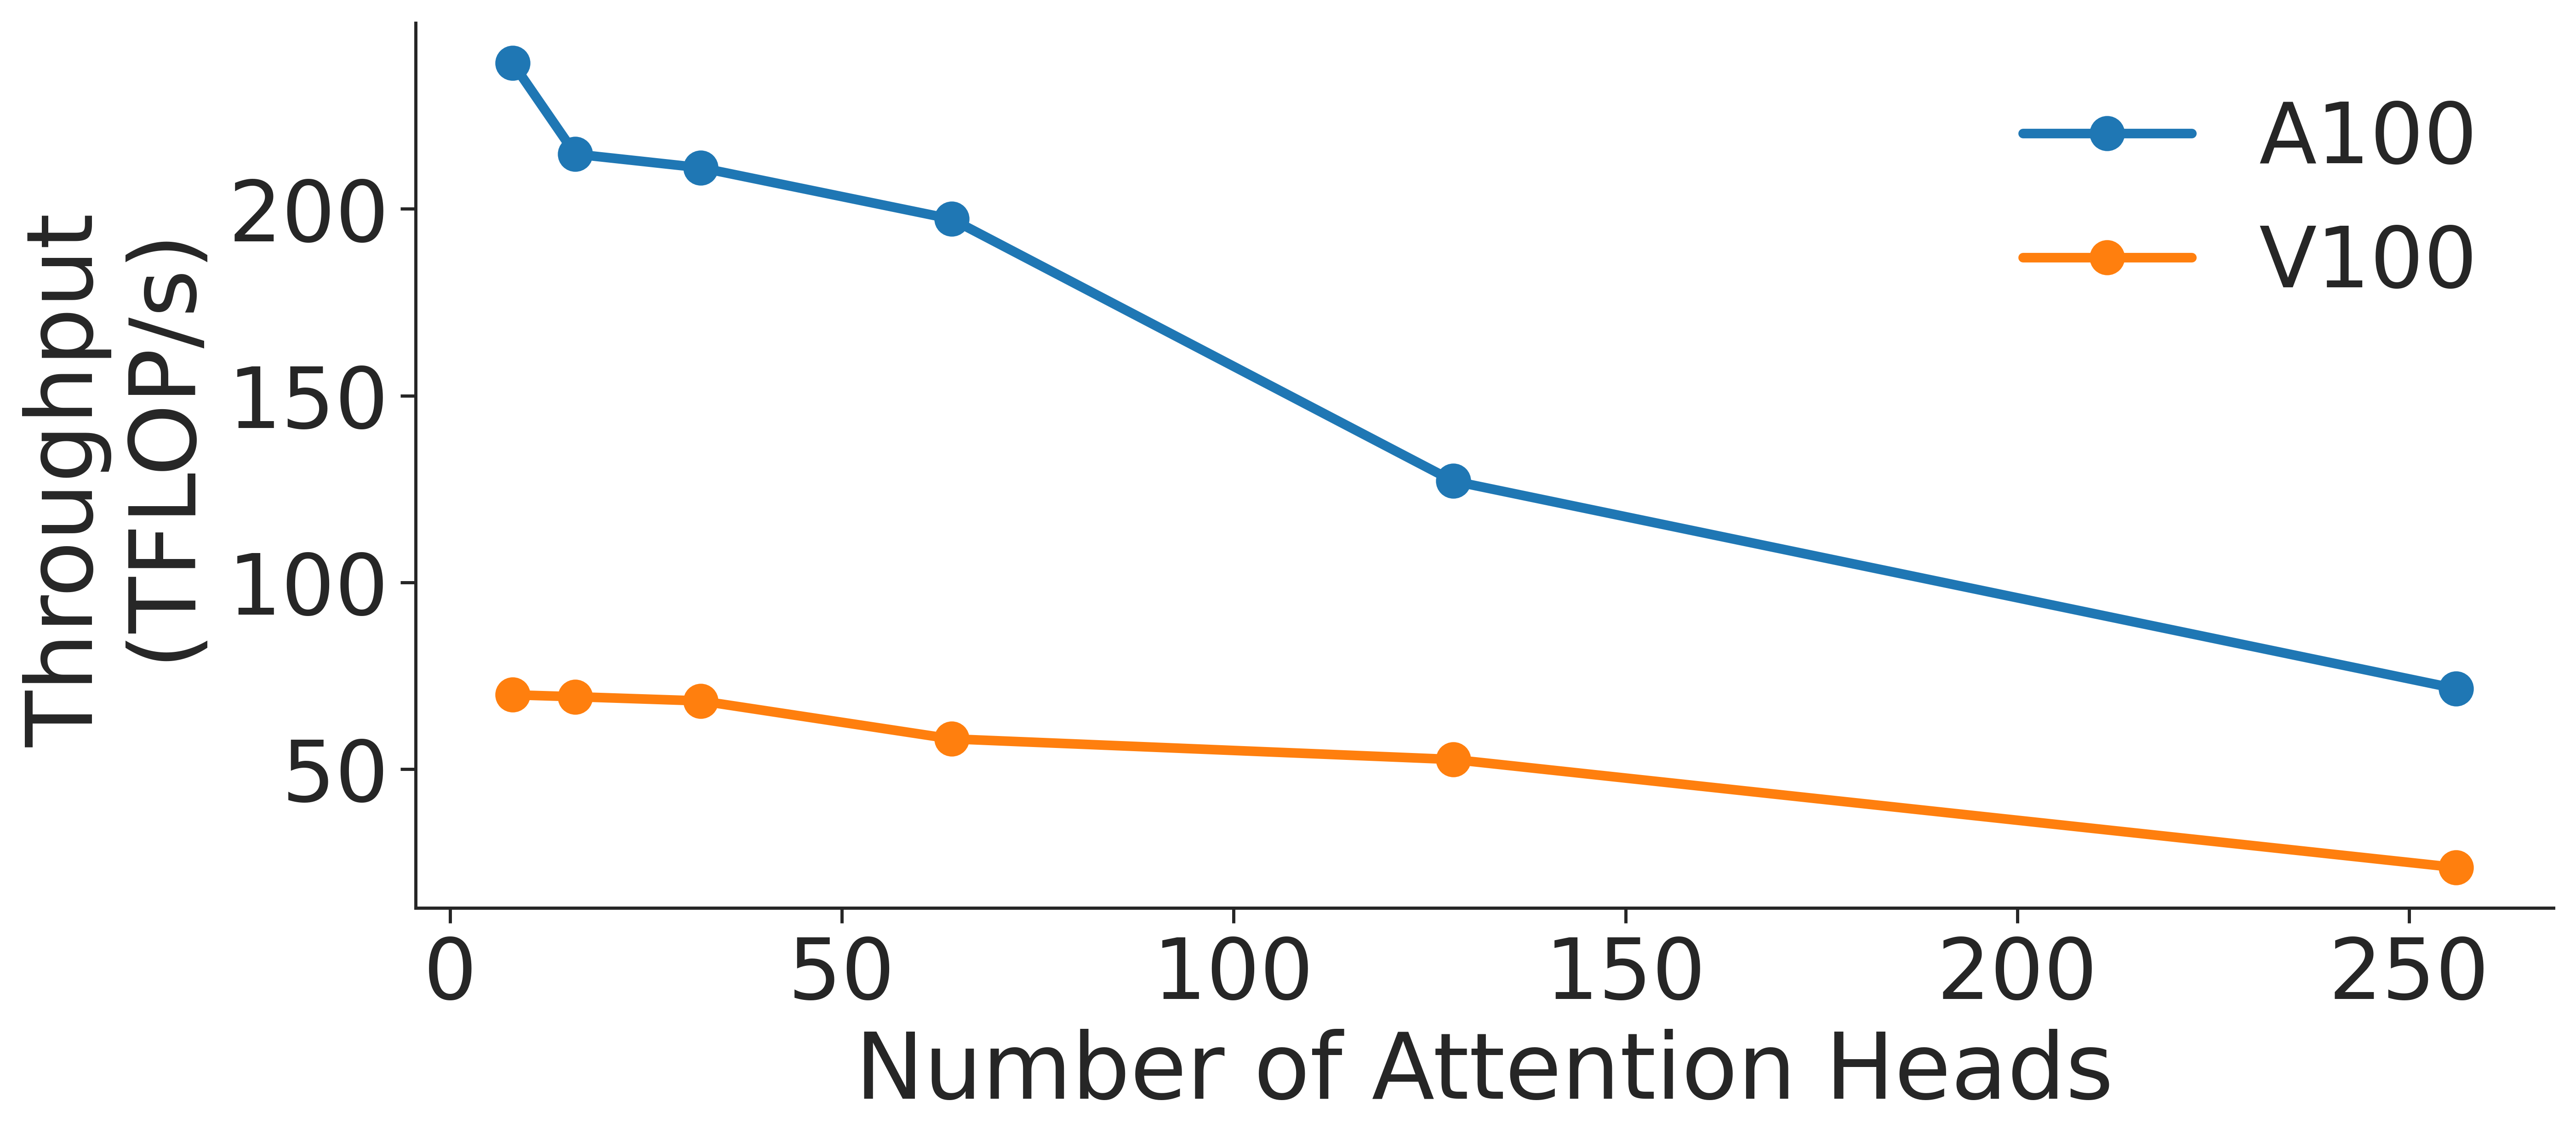

In [ ]:
plot_throughputs(read_logfile("scripts/A100_n_sweep.out"),read_logfile("scripts/V100_n_sweep.out"),
                 "num_attention_heads","Number of Attention Heads", "attention_prob_times_values","Throughput \n (TFLOP/s)")

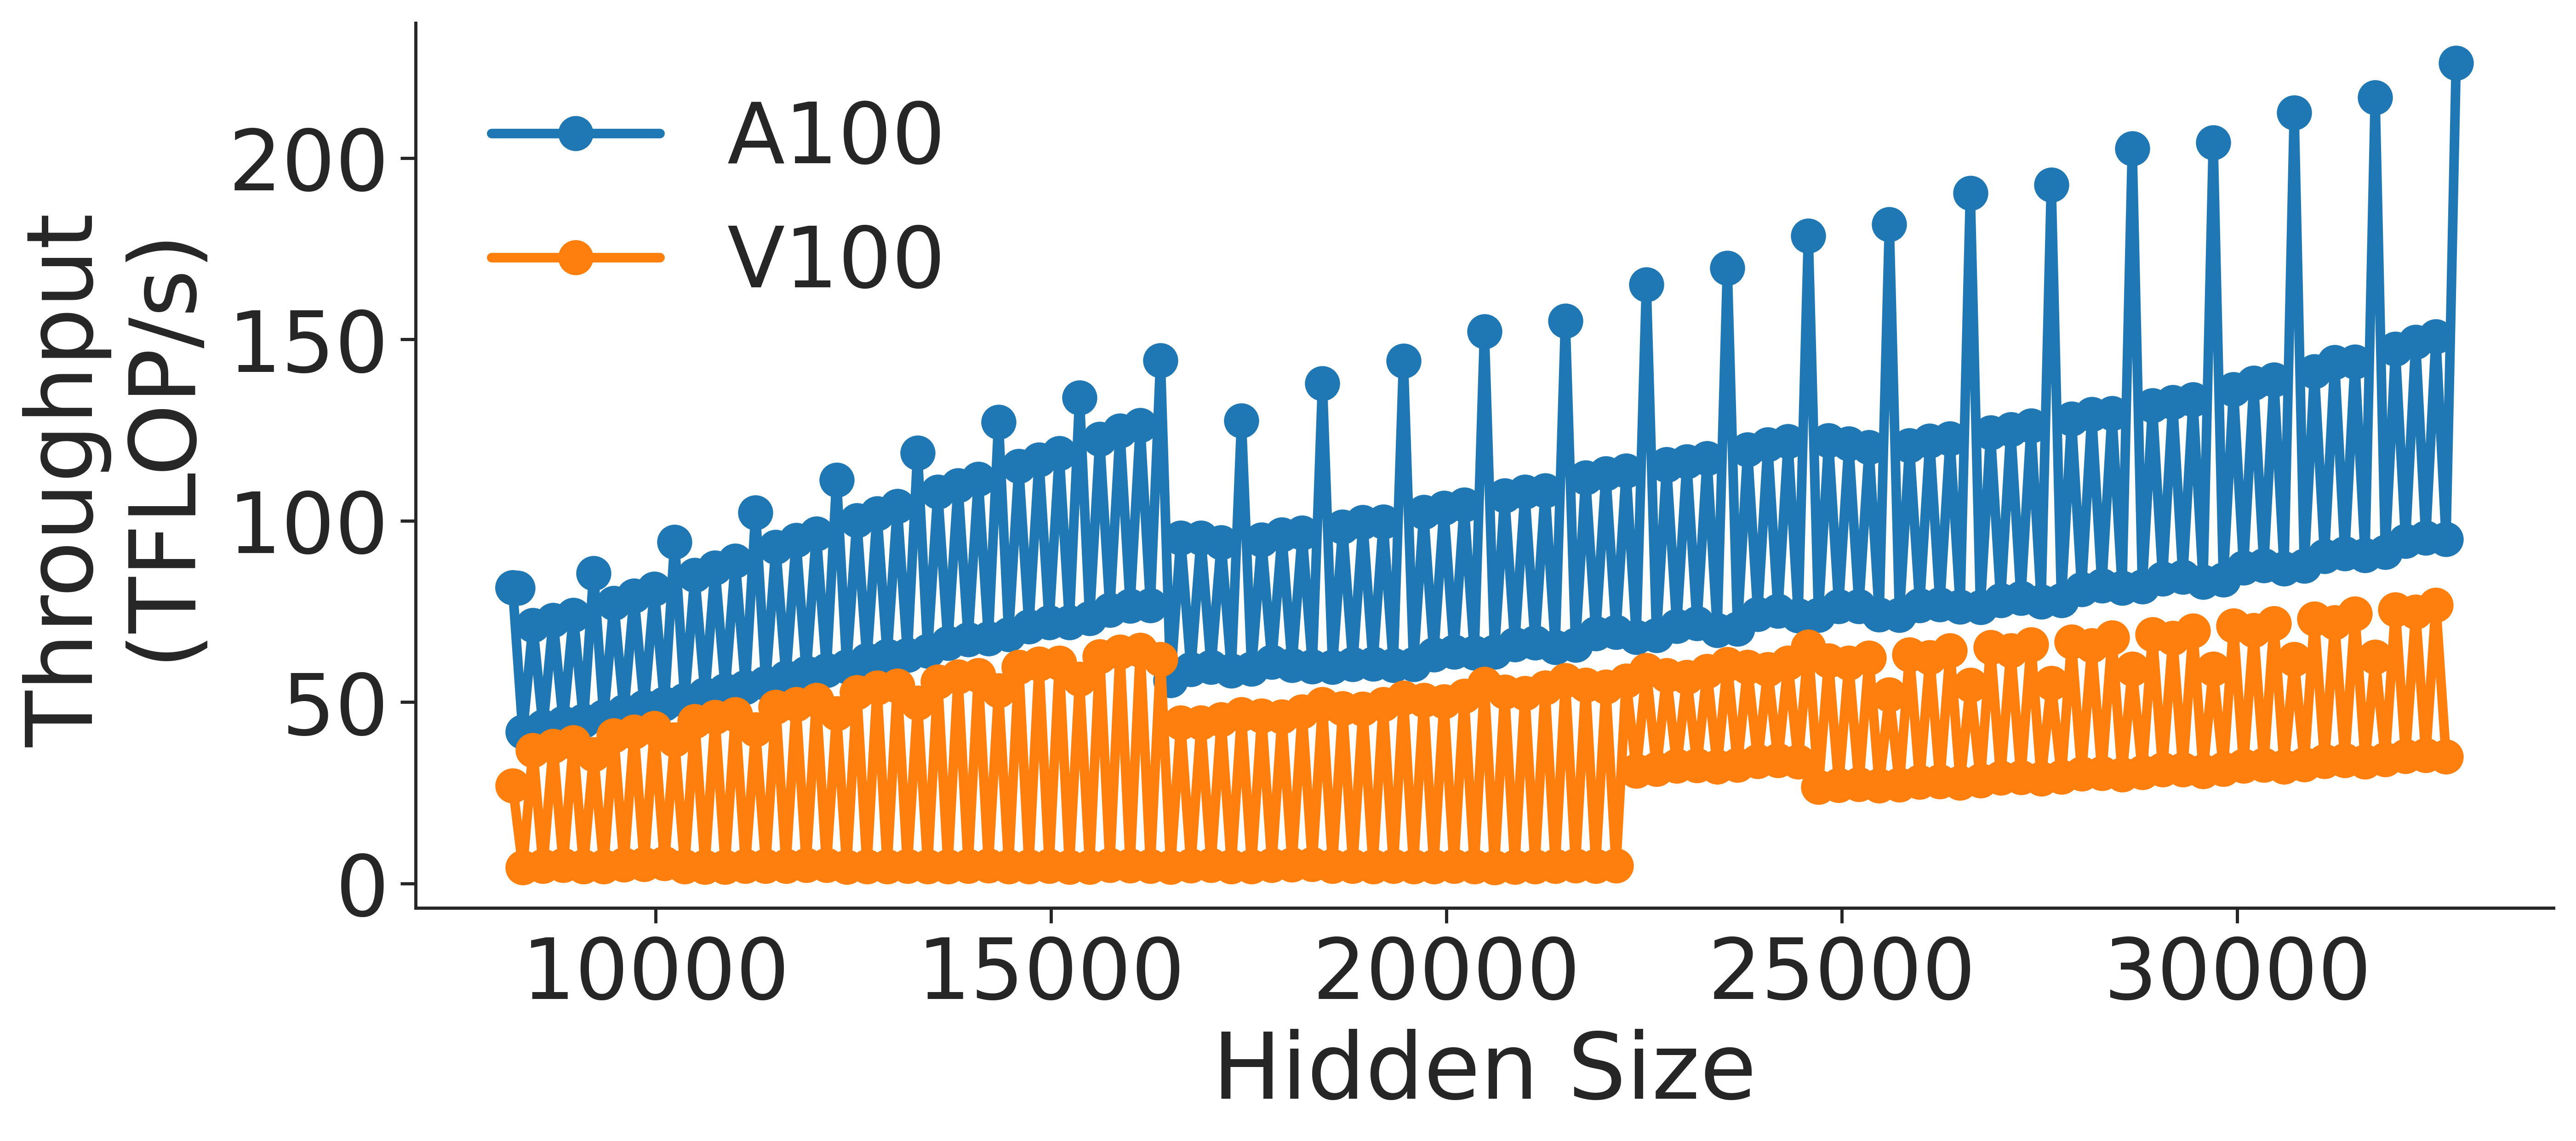

In [ ]:
plot_throughputs_hsweep(read_logfile("scripts/median_h_sweep.txt"),read_logfile("scripts/V100_h_sweep.out"),
                 "hidden_size","Hidden Size", "attention_prob_times_values","Throughput \n (TFLOP/s)")

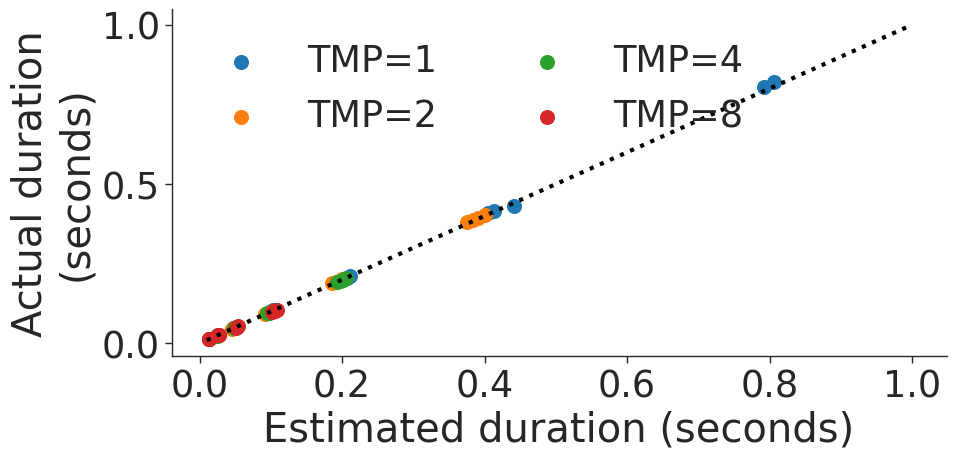

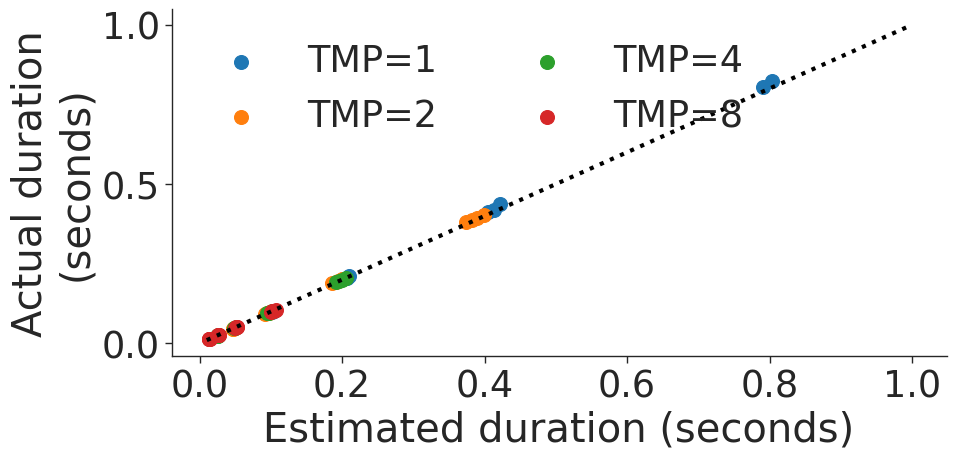

In [ ]:
plot_estimate_vs_actual(read_logfile_base("logs/transformer/v100/configuration_sweep.out"),
                        value_type_to_plot='duration',
                        groups=[{'tensor_mp_size': 1}, {'tensor_mp_size': 2}, {'tensor_mp_size': 4},
                                {'tensor_mp_size': 8}],
                        xlabel='Estimated duration (seconds)',
                        ylabel='Actual duration\n(seconds)',
                        min_x_and_y_value=0.01, max_x_and_y_value=1.0)
plot_estimate_vs_actual(read_logfile_base("logs/transformer/v100/configuration_sweep_v2.out"),
                        value_type_to_plot='duration',
                        groups=[{'tensor_mp_size': 1}, {'tensor_mp_size': 2}, {'tensor_mp_size': 4},
                                {'tensor_mp_size': 8}],
                        xlabel='Estimated duration (seconds)',
                        ylabel='Actual duration\n(seconds)',
                        min_x_and_y_value=0.01, max_x_and_y_value=1.0)

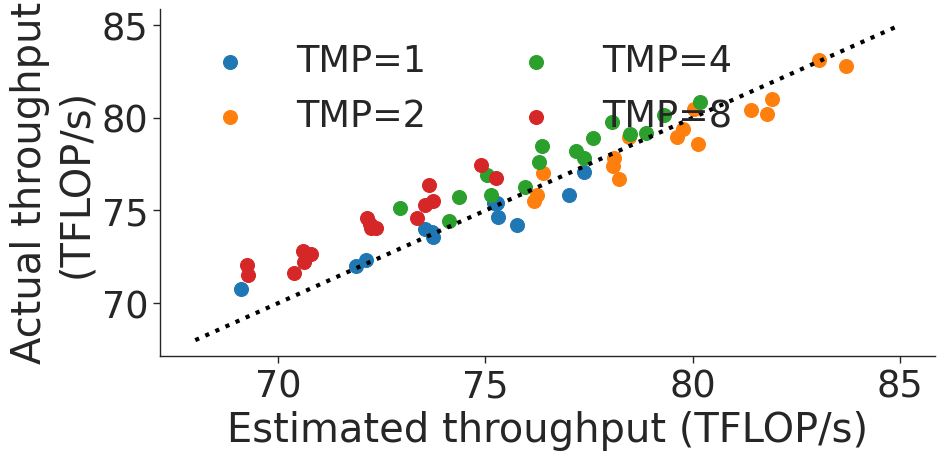

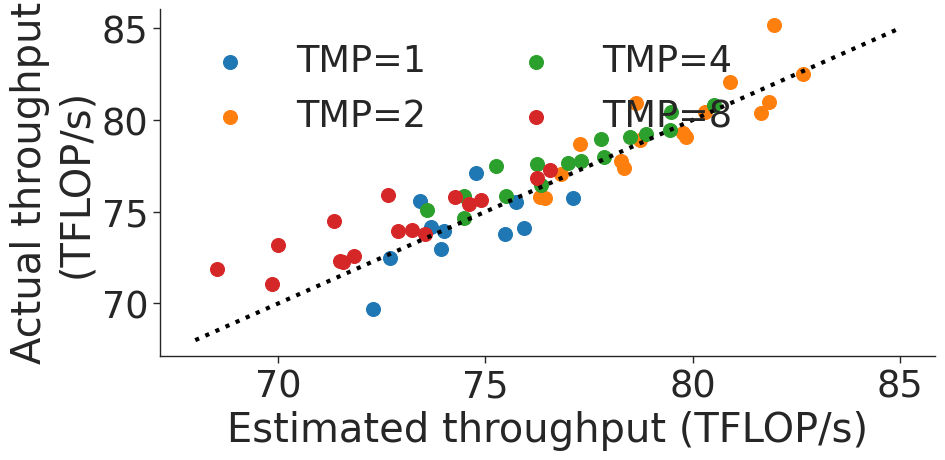

In [ ]:
plot_estimate_vs_actual(read_logfile_base("logs/transformer/v100/configuration_sweep.out"),
                        value_type_to_plot='throughput',
                        groups=[{'tensor_mp_size': 1}, {'tensor_mp_size': 2}, {'tensor_mp_size': 4},
                                {'tensor_mp_size': 8}],
                        xlabel='Estimated throughput (TFLOP/s)',
                        ylabel='Actual throughput\n(TFLOP/s)',
                        min_x_and_y_value=68, max_x_and_y_value=85)
plot_estimate_vs_actual(read_logfile_base("logs/transformer/v100/configuration_sweep_v2.out"),
                        value_type_to_plot='throughput',
                        groups=[{'tensor_mp_size': 1}, {'tensor_mp_size': 2}, {'tensor_mp_size': 4},
                                {'tensor_mp_size': 8}],
                        xlabel='Estimated throughput (TFLOP/s)',
                        ylabel='Actual throughput\n(TFLOP/s)',
                        min_x_and_y_value=68, max_x_and_y_value=85)

In [ ]:
def get_num_inversions(all_data):
    n = len(all_data)
    num_inversions = 0
    for i in range(n):
        for j in range(i+1, n):
            data1 = all_data[i]
            data2 = all_data[j]
            if (data1['estimated_throughput'] <= data2['estimated_throughput']) ^ \
               (data1['actual_throughput'] <= data2['actual_throughput']):
                num_inversions += 1
    fraction_inversions = num_inversions / (n*(n-1)/2)
    print(f"Fraction of inversions = {fraction_inversions:.3f}\n"
          f"Number of inversions = {num_inversions}")

In [ ]:
get_num_inversions(read_logfile("logs/transformer/v100/configuration_sweep.out"))

Fraction of inversions = 0.103
Number of inversions = 183


In [ ]:
get_num_inversions(read_logfile("logs/transformer/v100/configuration_sweep_v2.out"))

Fraction of inversions = 0.110
Number of inversions = 188


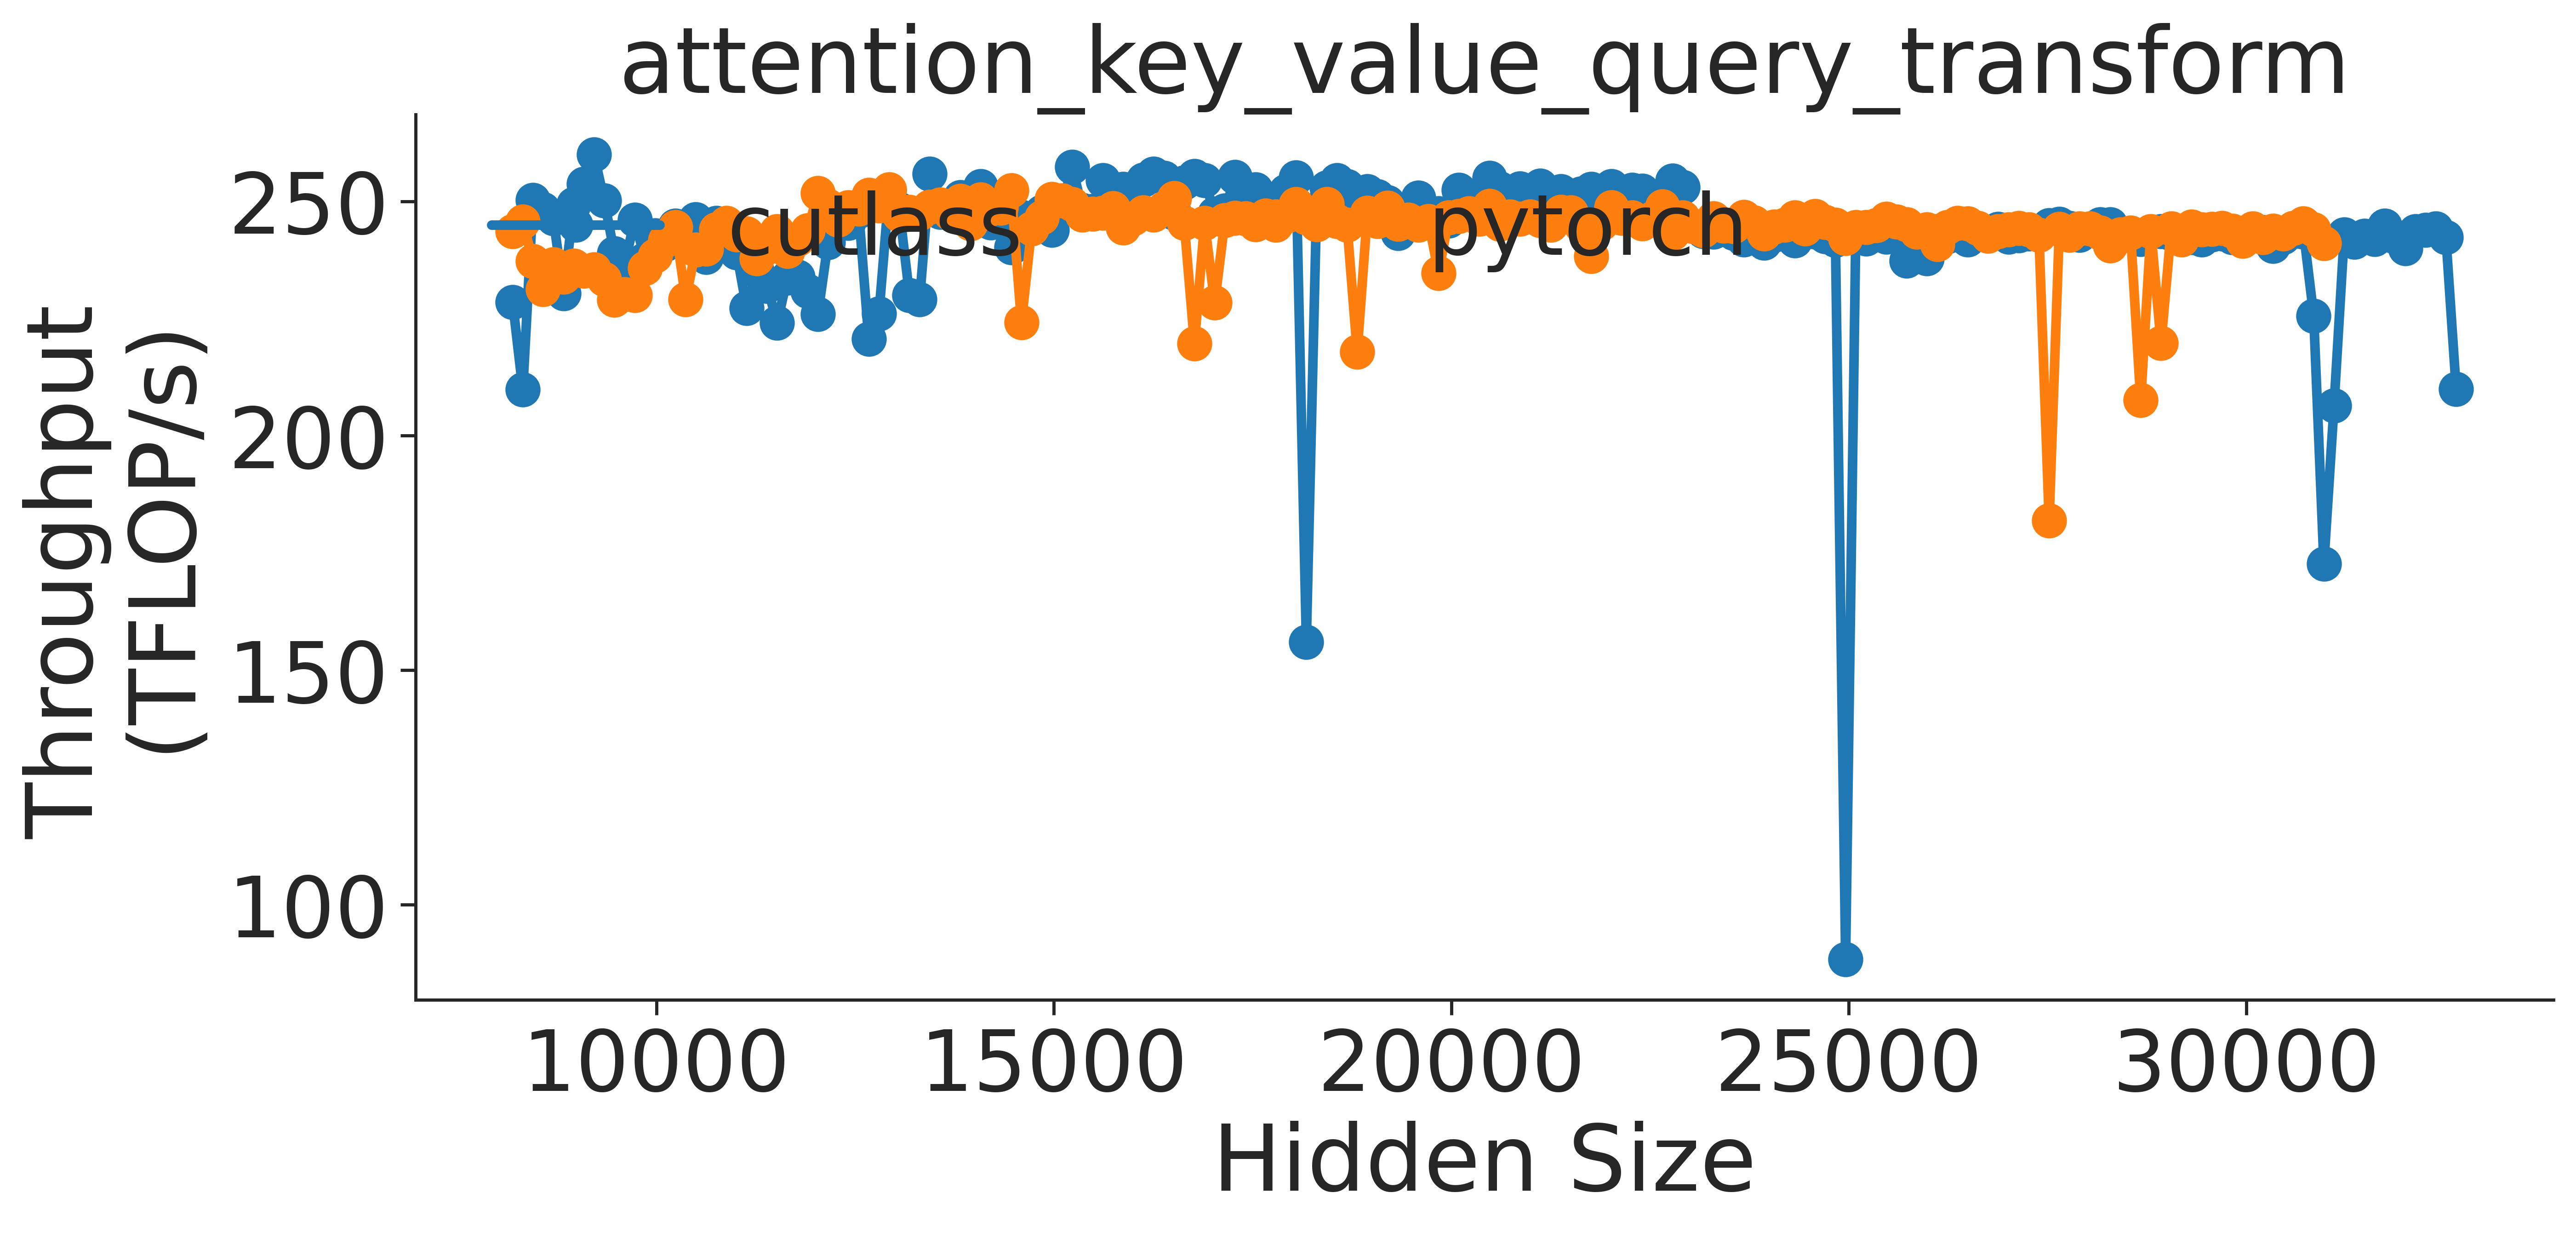

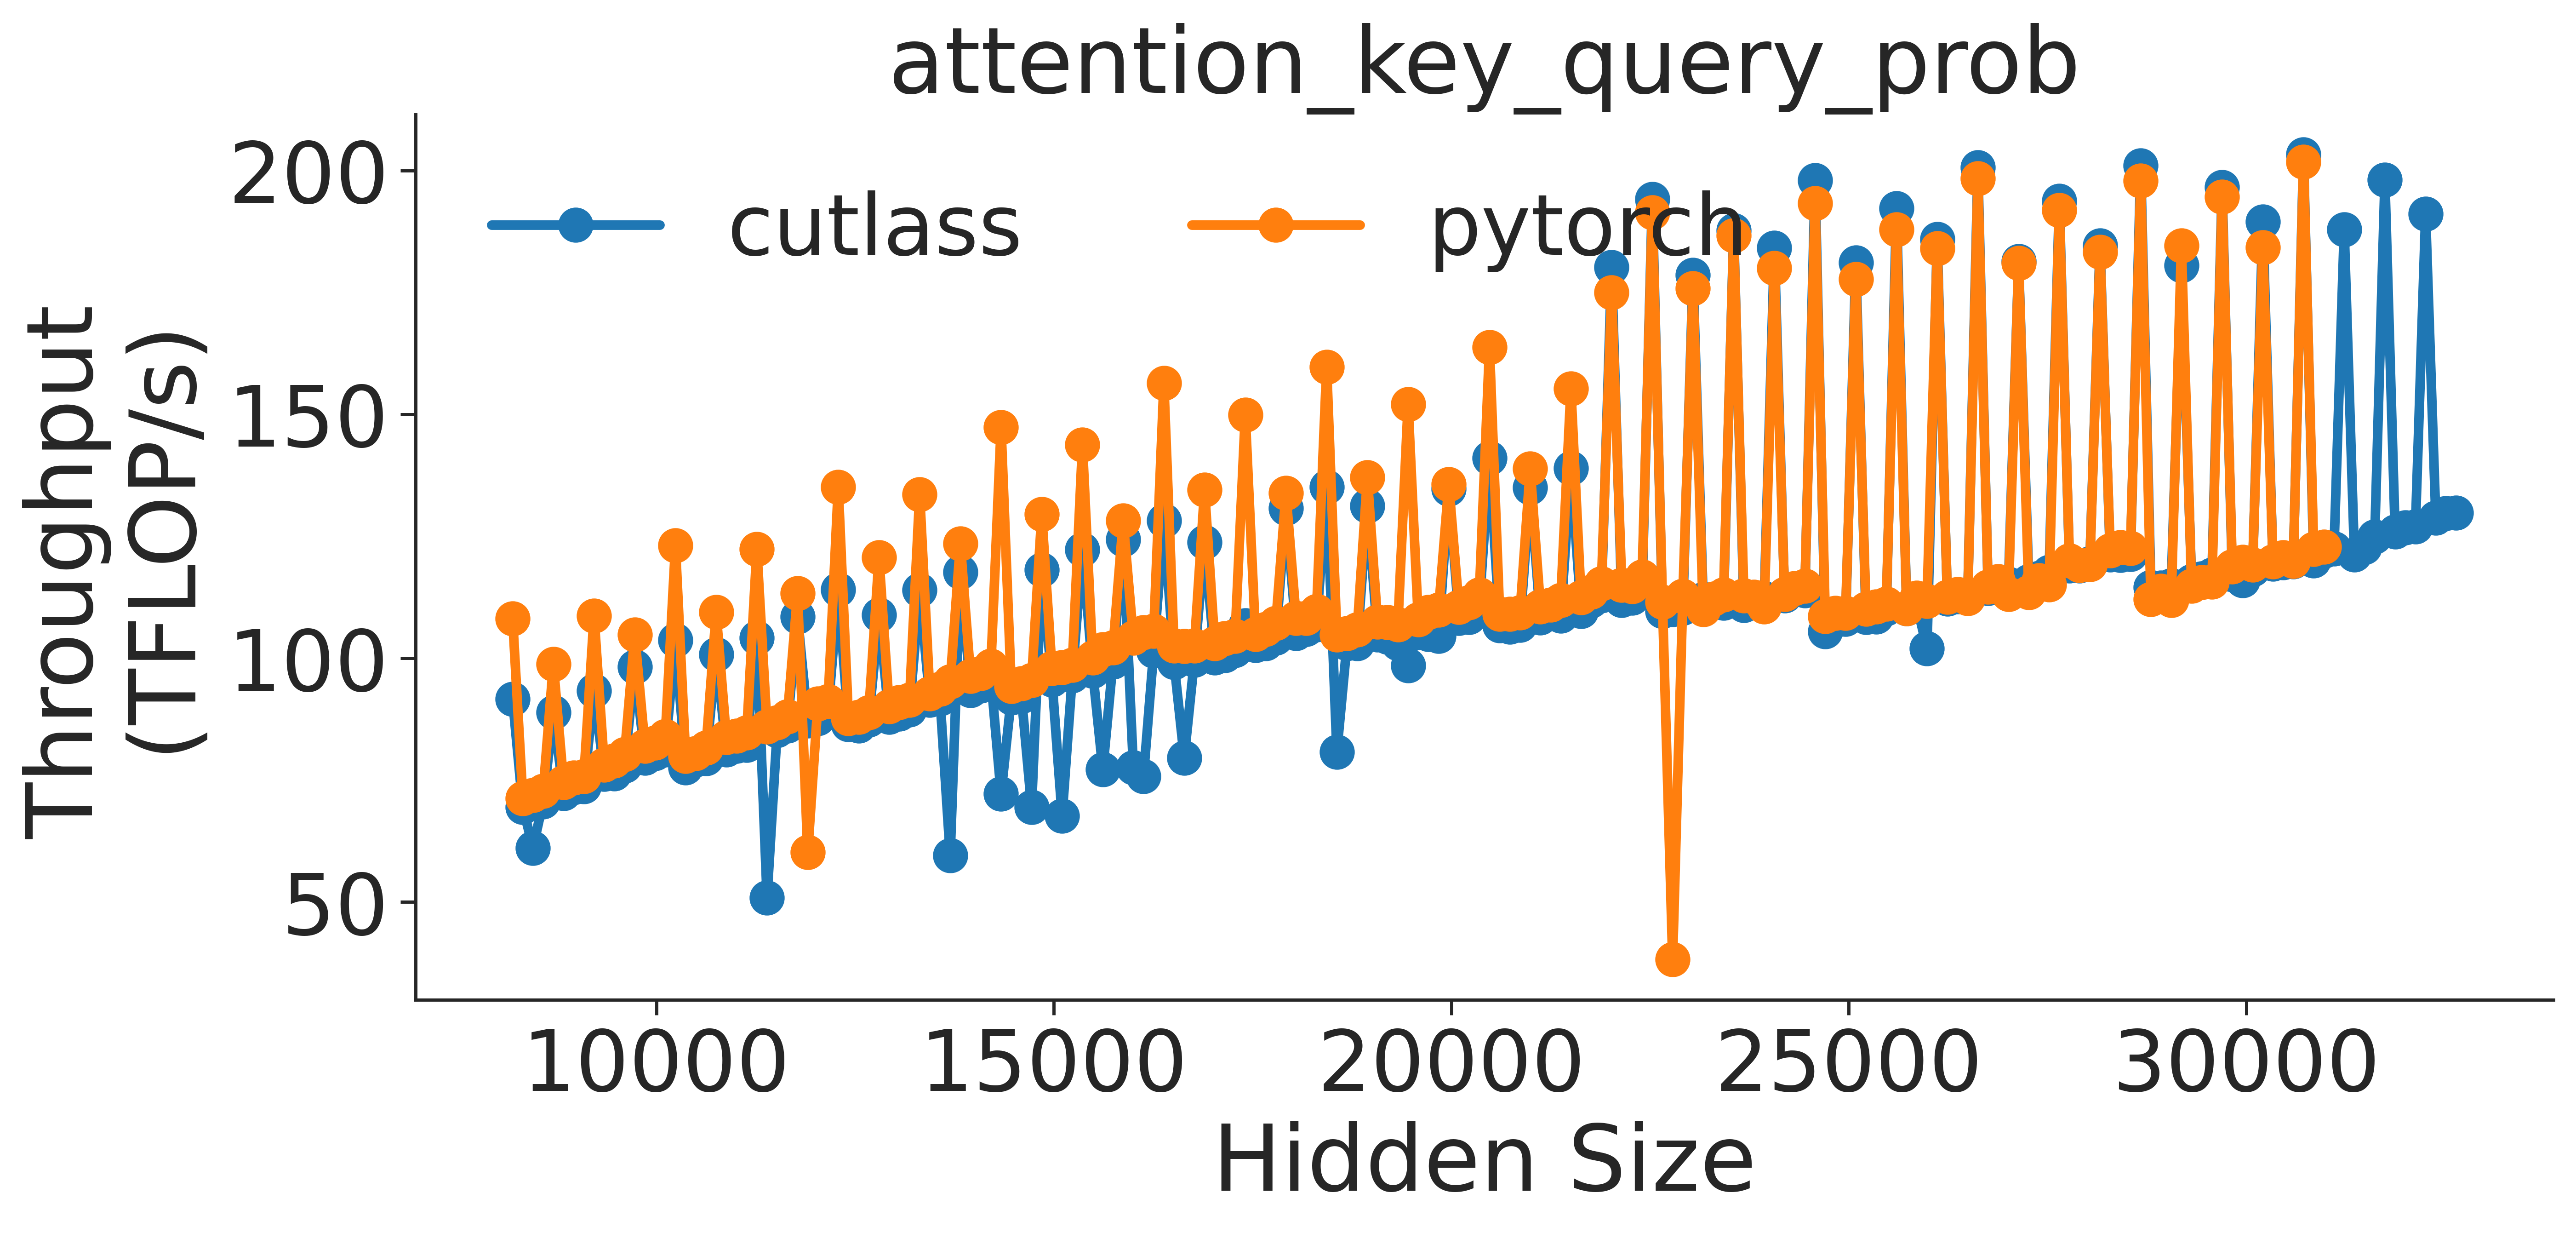

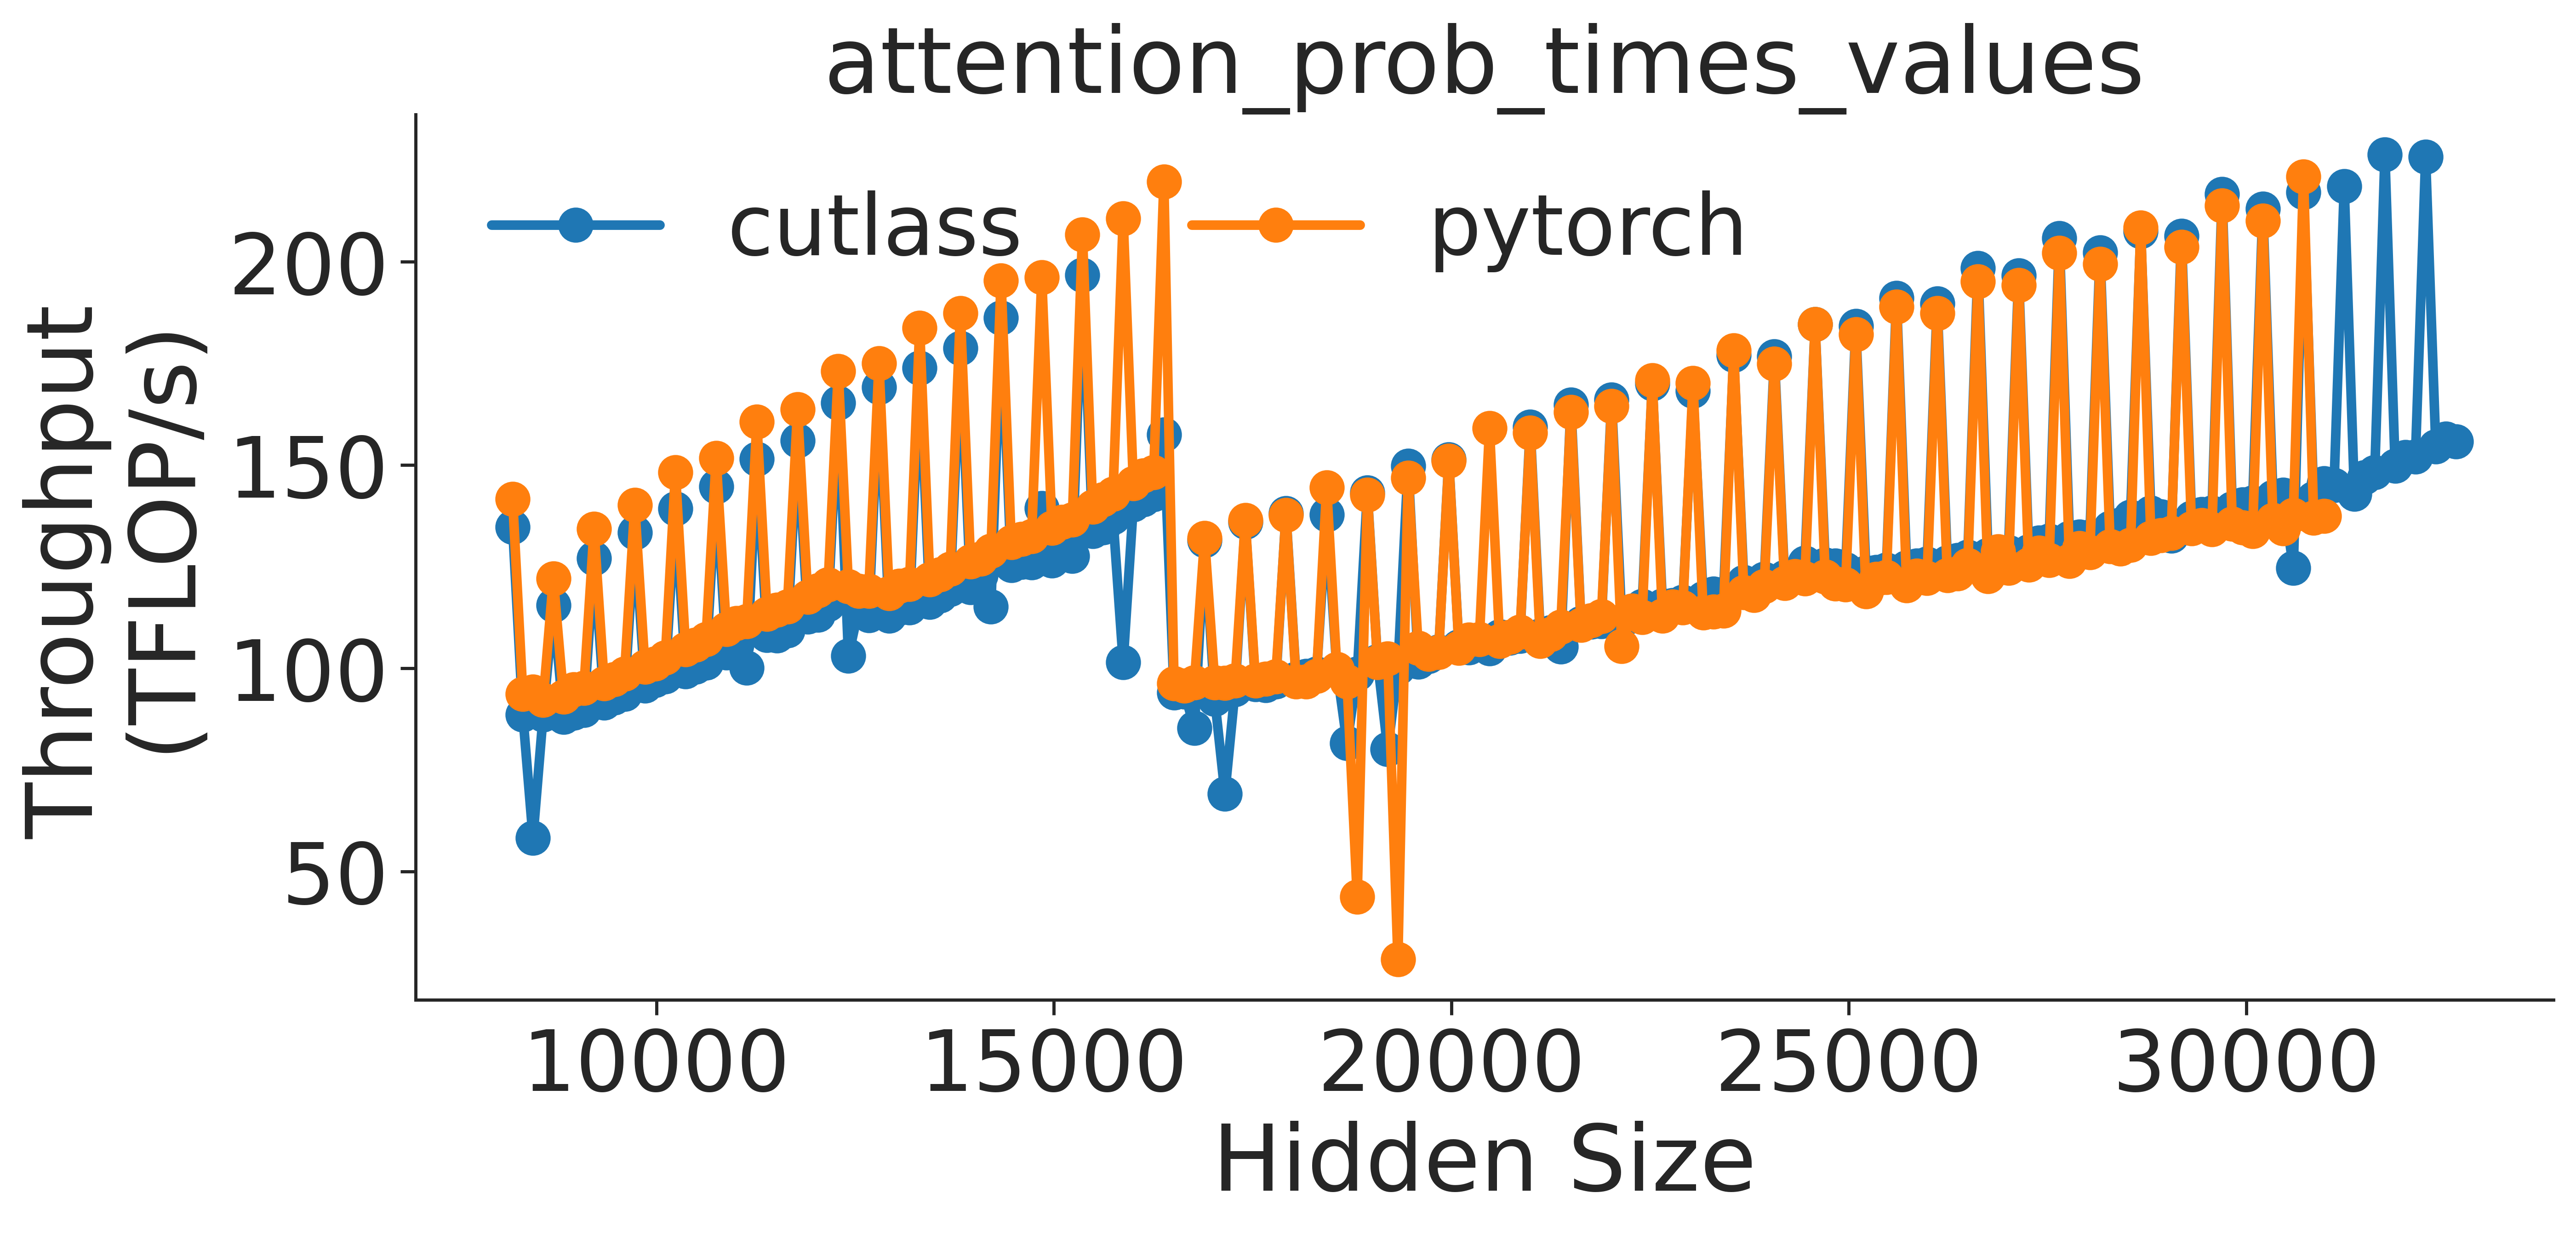

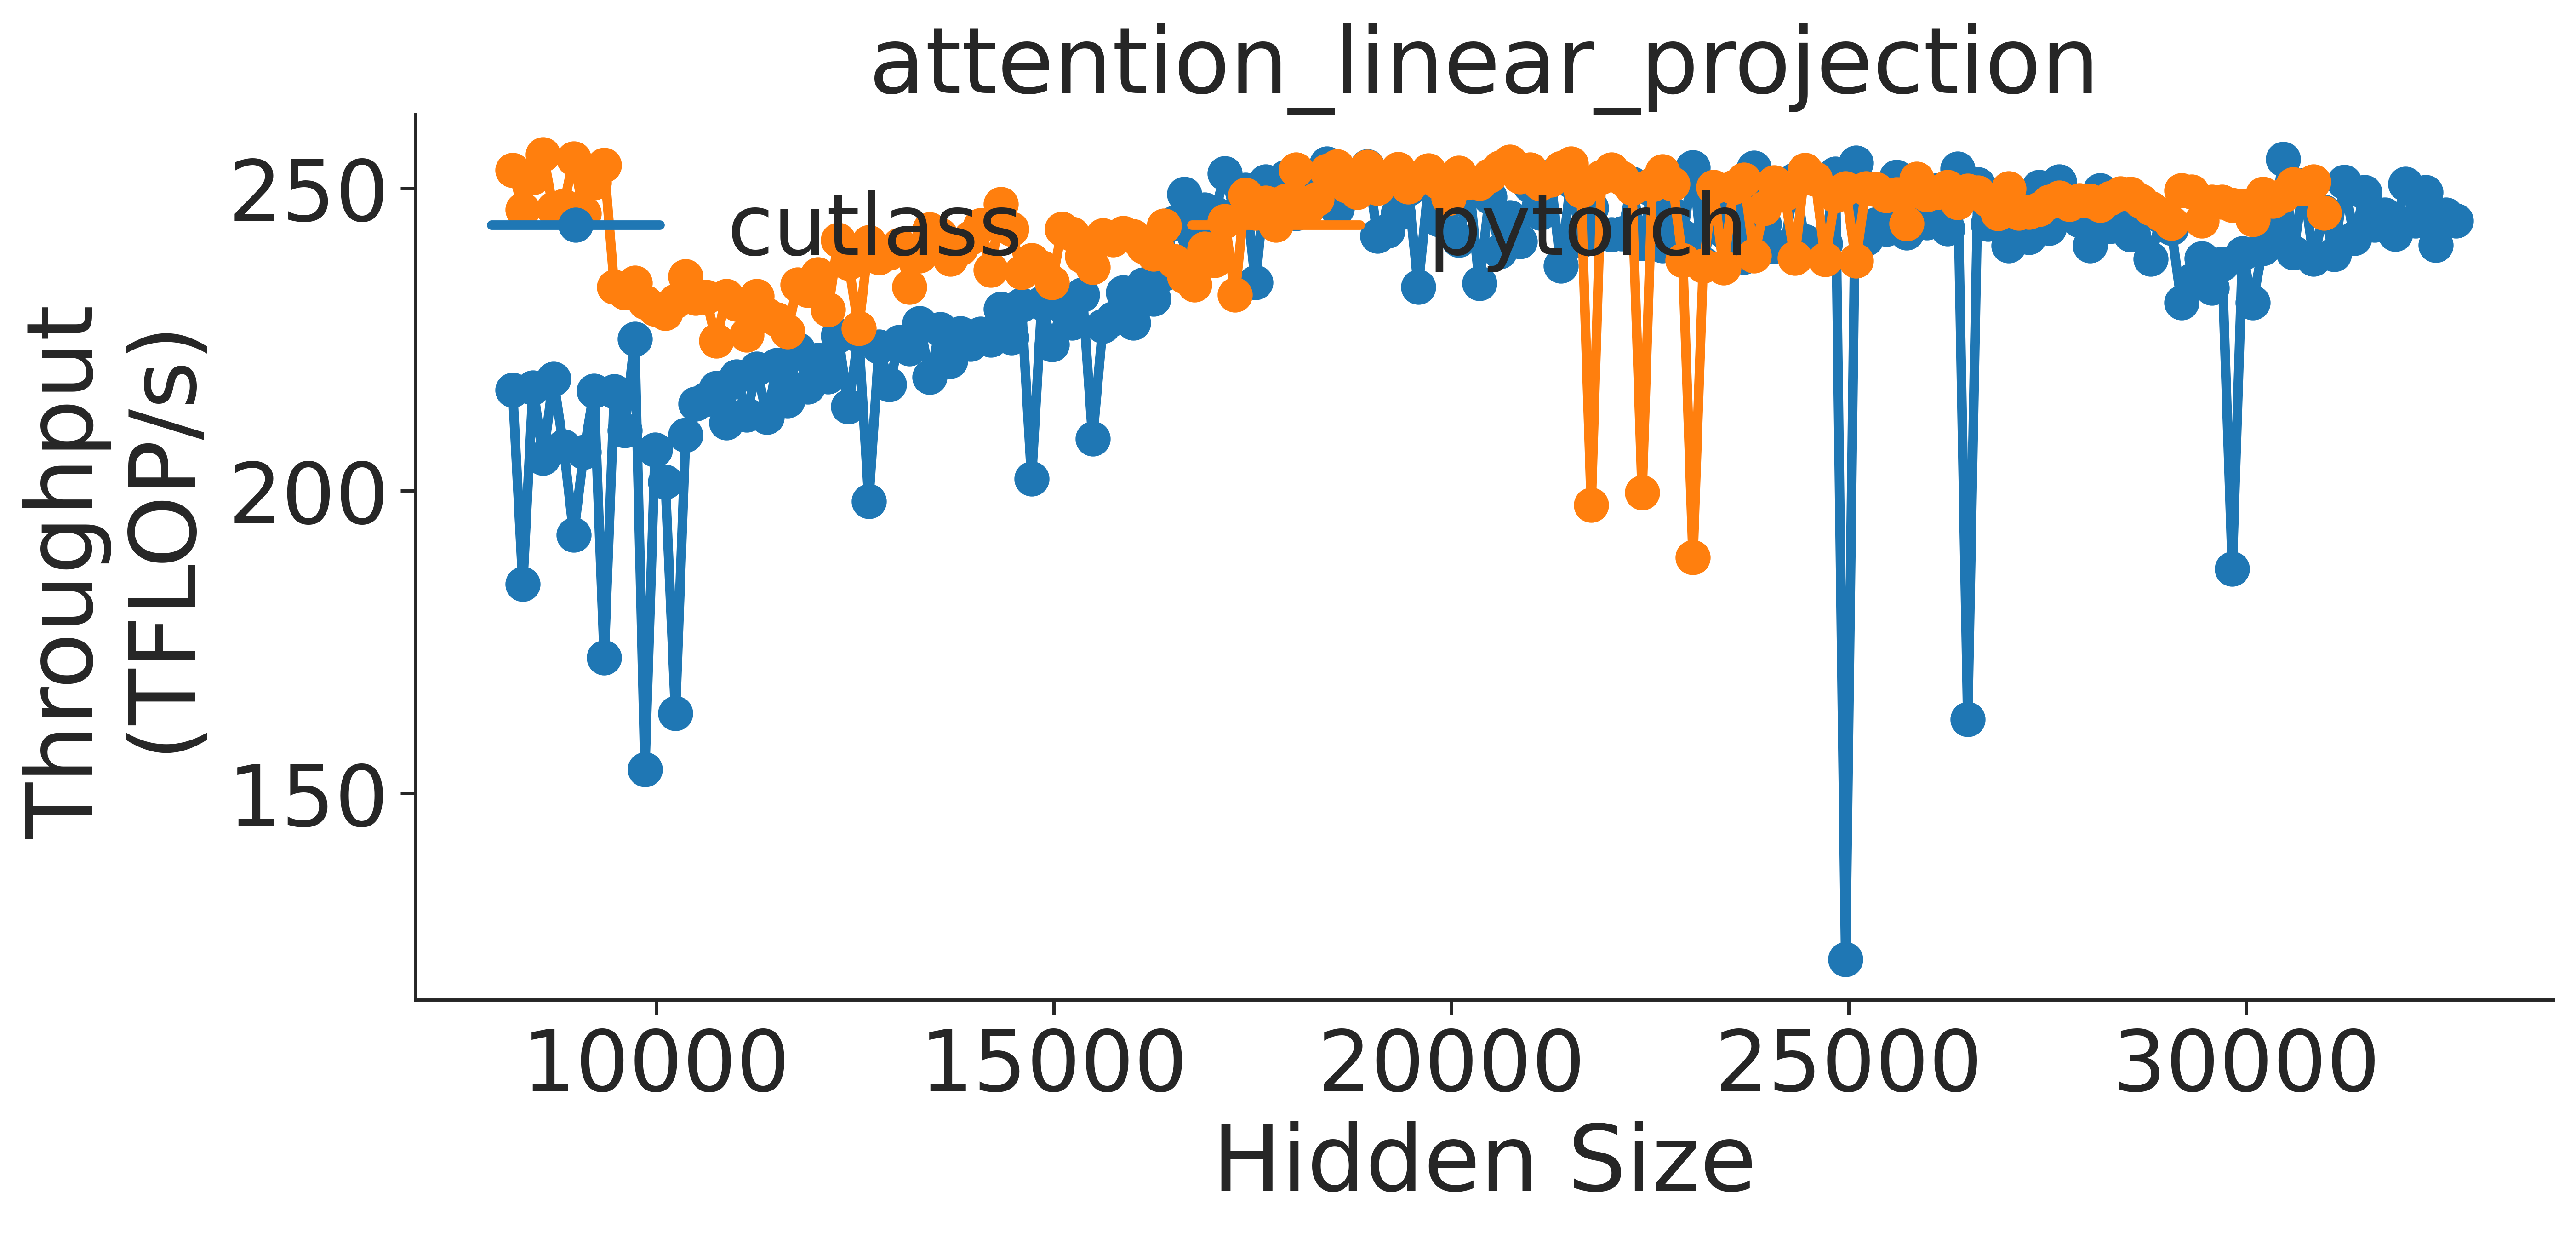

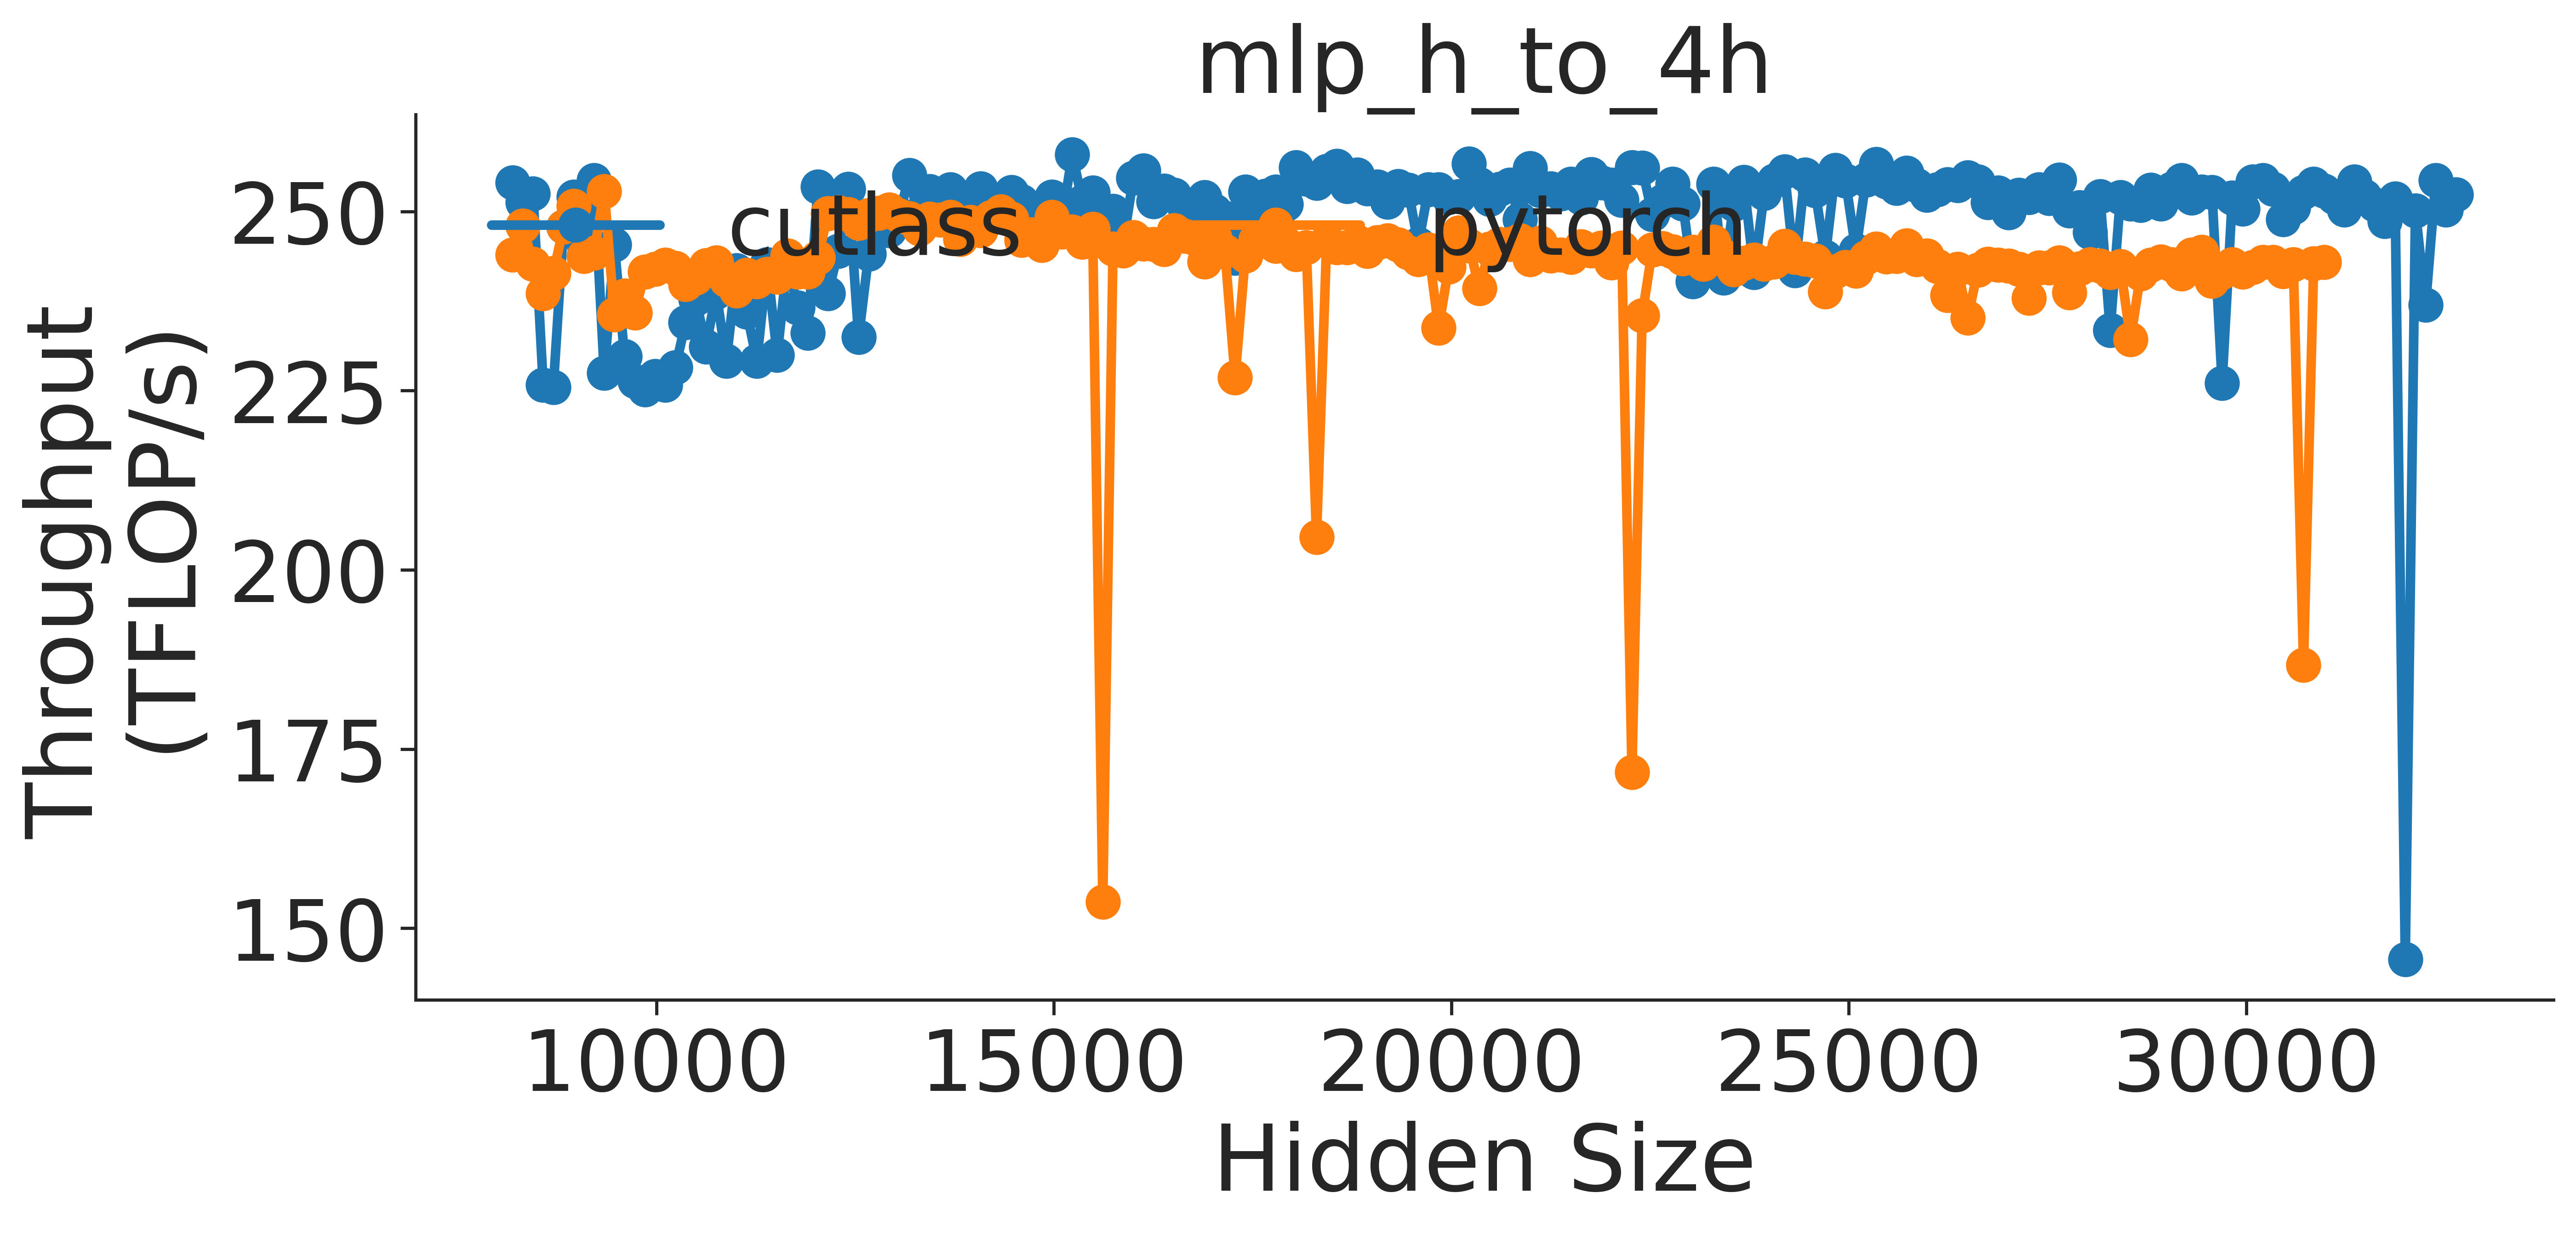

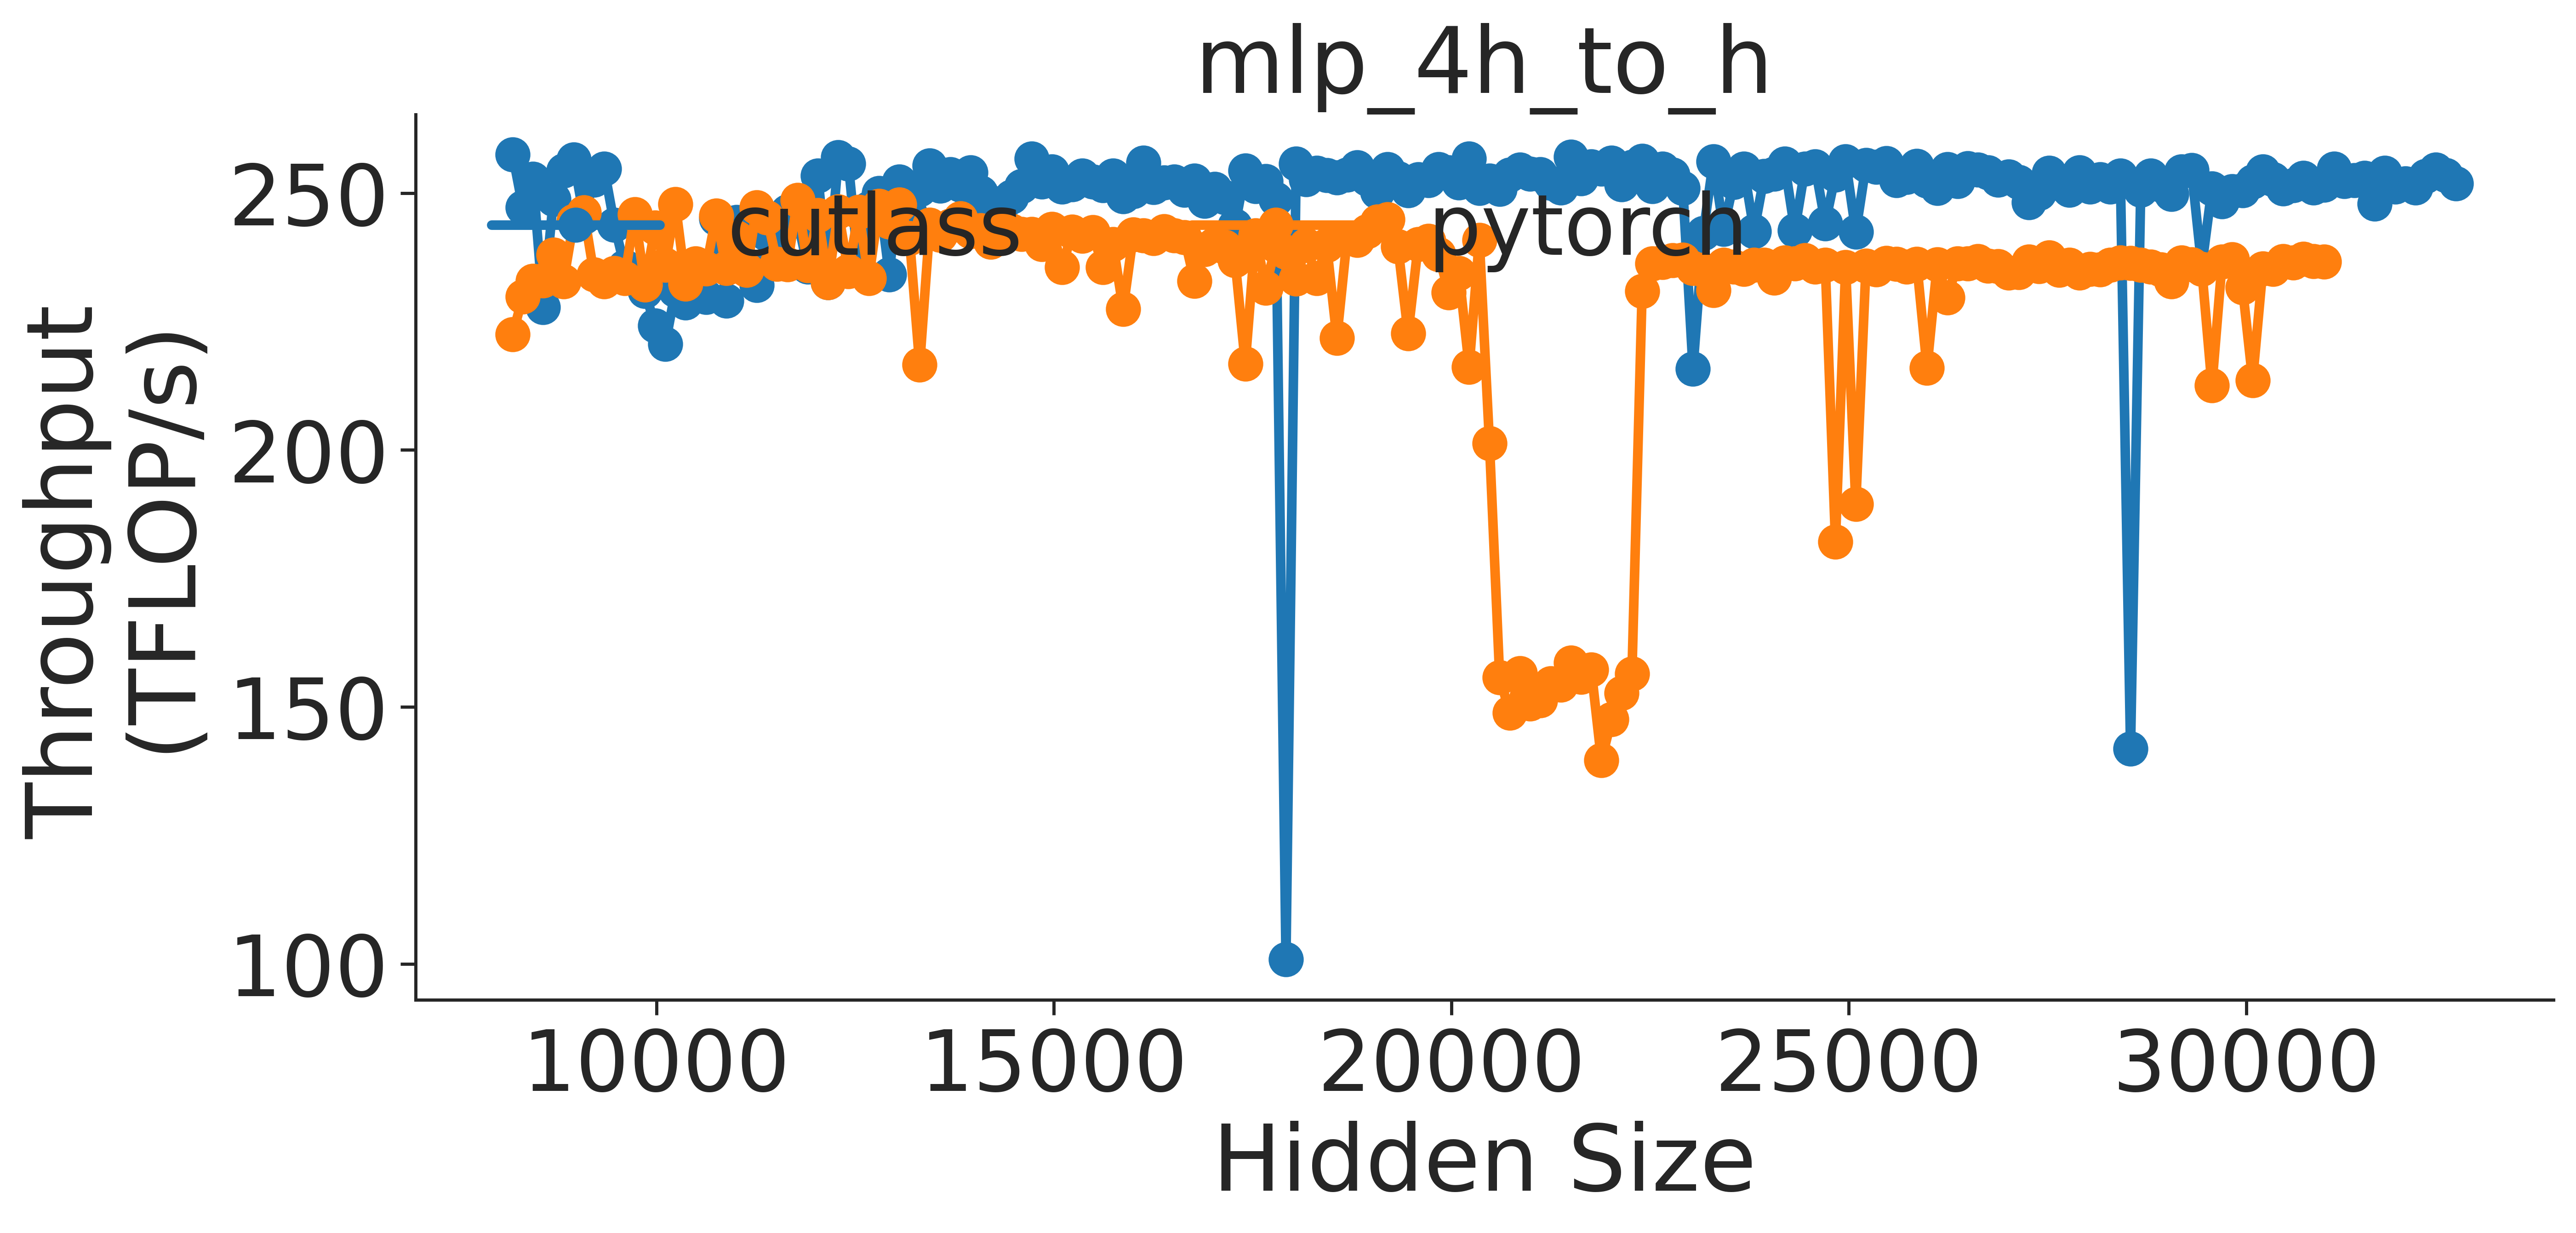

In [14]:
plot_vals = [
    "attention_key_value_query_transform",
    "attention_key_query_prob",
    "attention_prob_times_values",
    "attention_linear_projection",
    'mlp_h_to_4h',
    "mlp_4h_to_h"
]


plot_titles = [
    "Attention Key Value Query Transform",
    "Attention Key Query Problem",
    "Attention Problem Times Values",
    "Attention Linear Projection",
    "MLP h to 4h",
    "MLP 4h to h"
]


for i in range(len(plot_vals)):
    plot_cutlass_v_pytorch(read_logfile("results/max_h_sweep.out"), read_logfile("results/max_output_torch.out"), plot_vals[i])        

IndexError: list index out of range

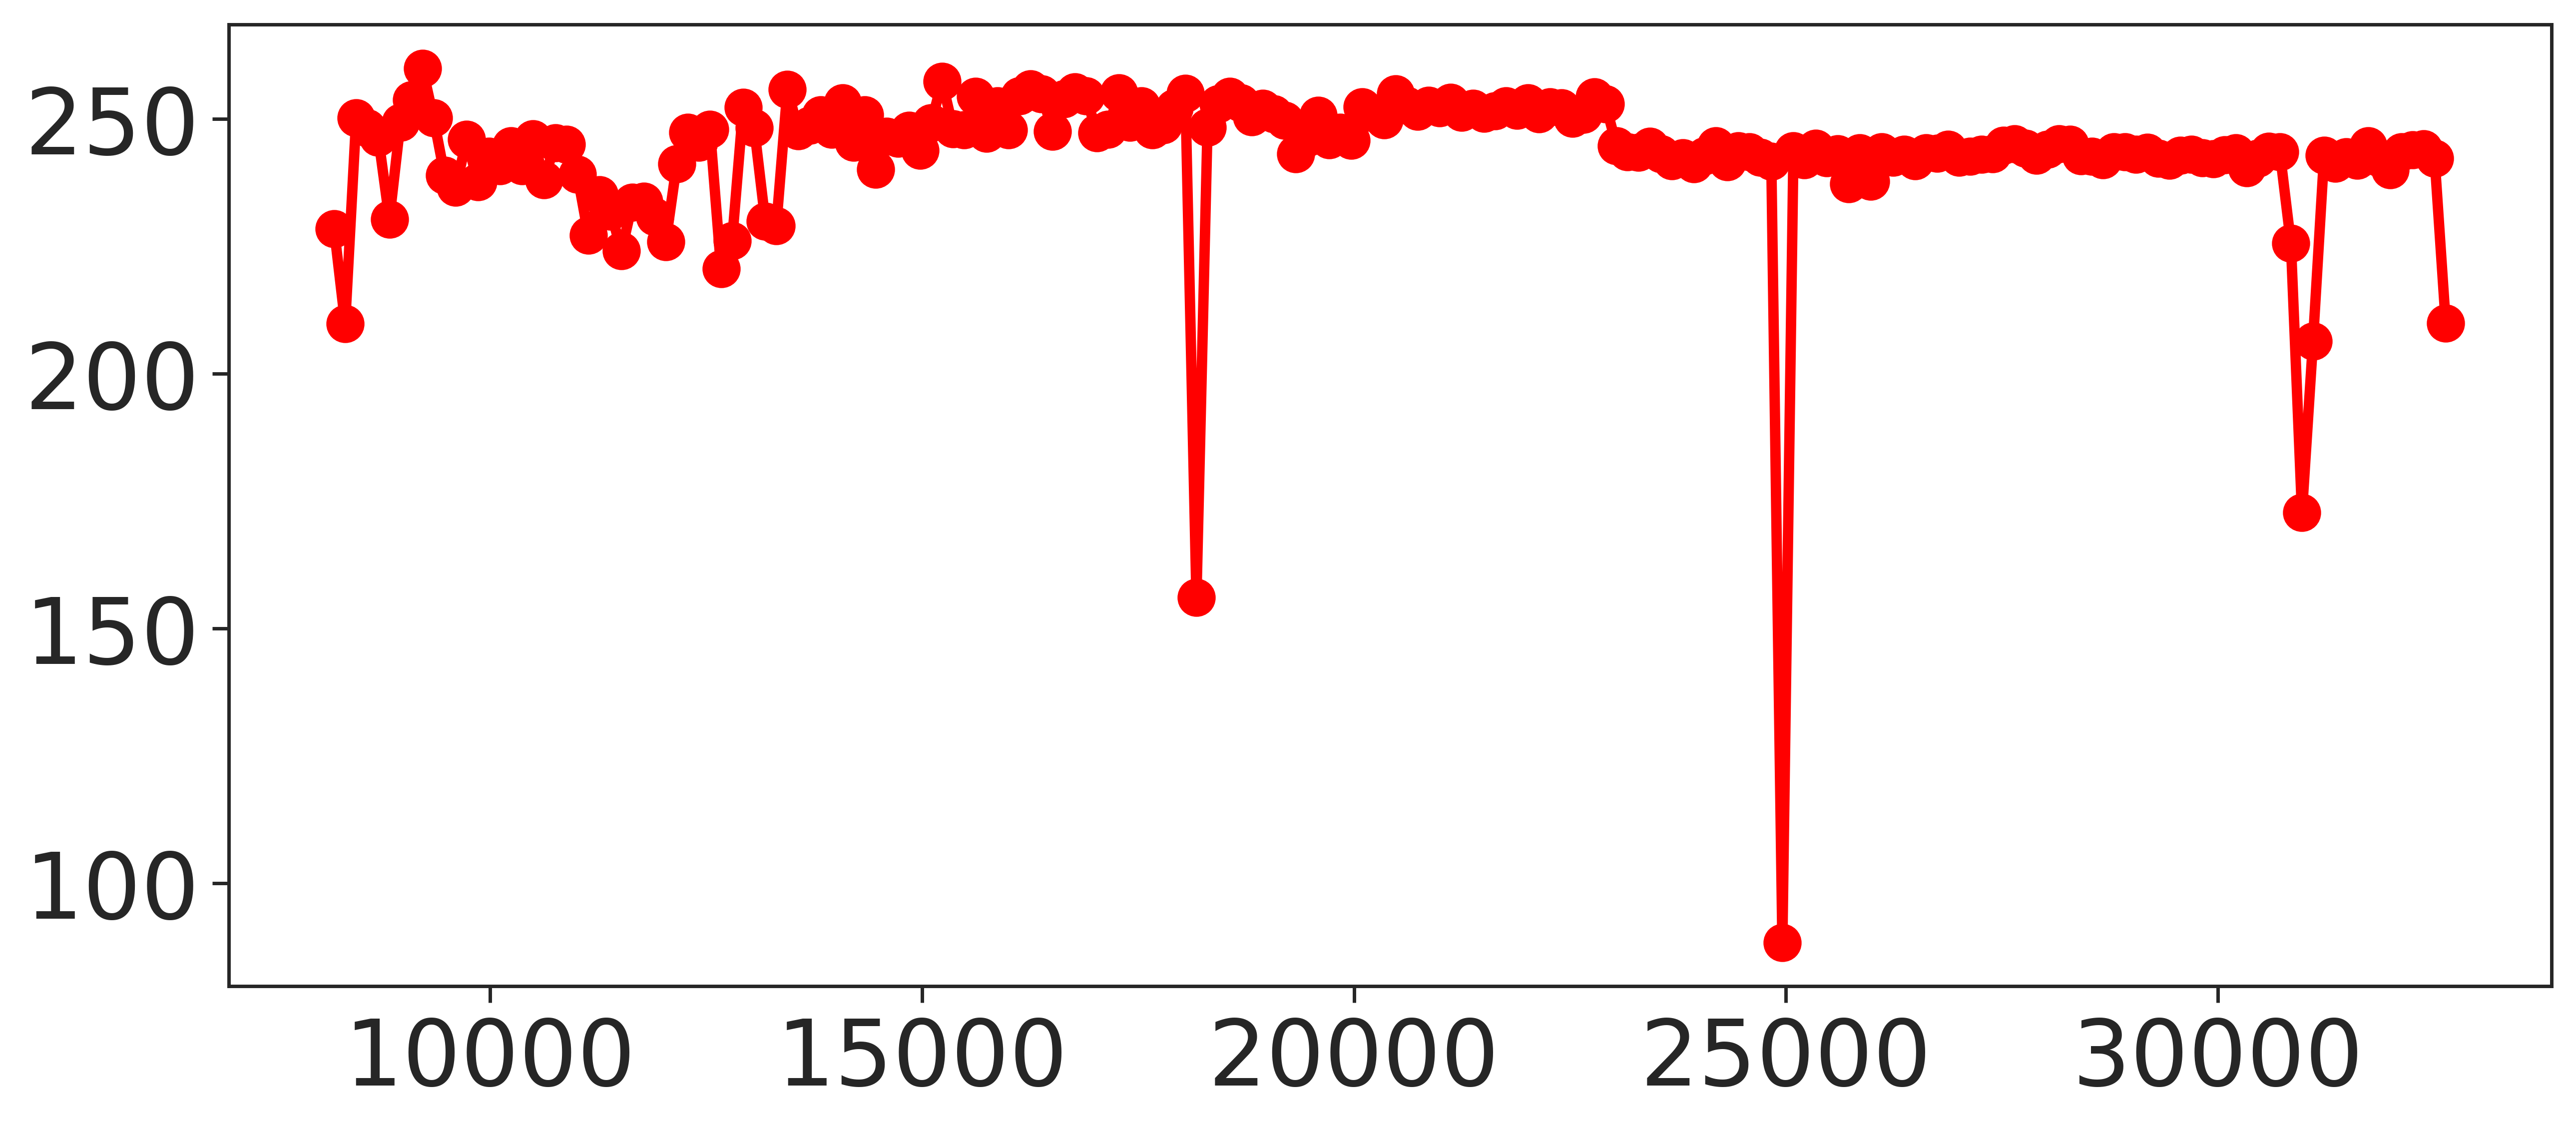

In [13]:
for i in range(len(plot_vals)):
    plot_hidden_sweep(read_logfile("results/max_h_sweep.out"),plot_vals[i], plot_titles[i], point_plot=[])        

Text(0.5, 0, 'all repeats')

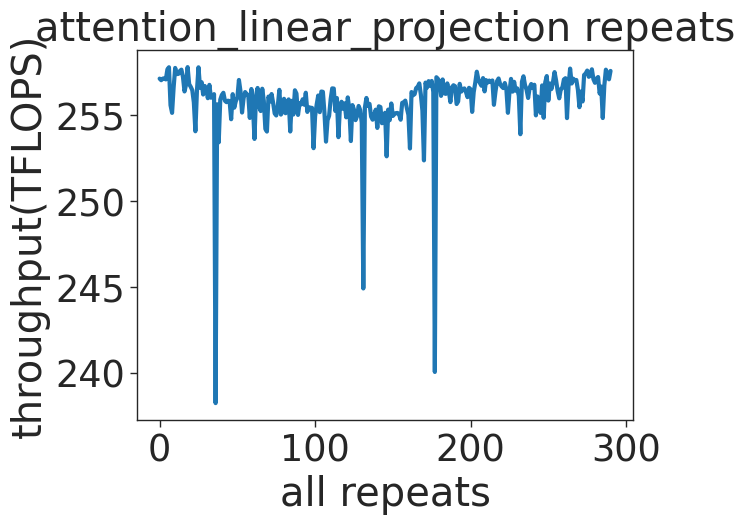

In [ ]:
throughputs = read_repeats("scripts/h_13056_repeat.txt")
plt.plot(throughputs)
plt.title("attention_linear_projection repeats")
plt.ylabel("throughput(TFLOPS)")
plt.xlabel("all repeats")